# TA - Procesamiento Digital de Señales
#### David Alonso Escobedo - 20210850

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import firwin, freqz

plt.rcParams['font.size'] = '10'
%matplotlib inline

## 1. Diseño de filtros digitales

Se desea diseñar filtros pasabajos para aplicaciones de radar. Considere que contamos con un sistema de recepción de señales de radar basado en un dispositivo SDR (Software Defined Radio) que adquiere datos con una velocidad de muestreo de 100 MHz. La señal digitalizada pasa por un demodulador para llevar la señal a banda base, por un filtro pasabajos y por un decimador para reducir la tasa de muestreo a 1 MHz. Por ende, la frecuencia de corte del filtro a diseñar también debe ser de 1 MHz.

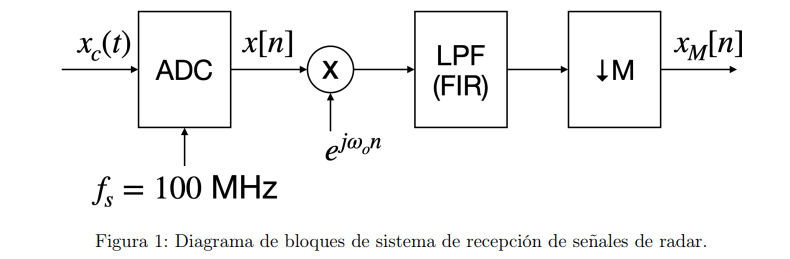

Los parámetros que caracterizan un filtro digital están descritos en la siguiente figura.

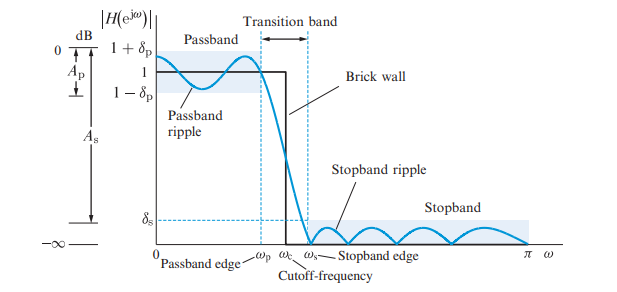

1. Se desea realizar el diseño aplicando la técnica de enventanado, utilizando una ventana de tipo Kaiser. Para ello considere que la atenuación en la banda de rechazo es de 80 dB. Además, seleccione la longitud del filtro tal que la banda de transición sea como máximo el 10% de la frecuencia de muestreo luego de la decimación.

> Según Manolakis & Ingle una ventana útil para el diseño de filtros debe tener una transformada de Fourier con el lóbulo principal estrecho y lóbulos laterales de valores picos relativamente pequeños y una de gran atenuación.
> 
> Se buscan esas caracteristicas ya que el ancho del lóbulo principal de la transformada determina aproximadamente el ancho de la banda de transición, además la altura relativa de los lóbulos laterales controla el tamaño de las ondulaciones pasada la frecuencia de corte.
>
> Manolakis & Ingle también explican que hay un compromiso o relación entre estas dos métricas (ancho del lóbulo principal y altura de los lóbulos laterales) ya que no se puede reducir ambas métricas al mismo tiempo.
>
> Existen varias soluciones o métodos para afrontar esta problemática, la ventana de Kaiser desarrollada por Saramaki en 1993 es una combinación de dos enfoques, utiliza las funciones de onda esferoidales prolatas y la ventana de Dolph-Chebyshev.

> La ventana de Kaiser se define como:
>
> $ \mathcal{w}[n] = \left\{ \begin{array}{lcc} \dfrac{ \mathcal{I_{0}} (\beta \sqrt{1 - (\frac{ n - α }{α})^2} ) }{ \mathcal{I_{0}} (\beta) } & si & 0 \leq n \leq M \\
>  \\ 0 & , & c.c. \end{array} \right.$
>
> Donde:
> 
> - $\mathcal{I_{0}}$ es la función de Bessel modificada de primer tipo y orden cero.
> 
> - $\beta$ es un parámetro que controla la forma de la ventana.
> 
> - $α = M/2$, donde $M$ es el tamaño de la ventana.

> La función de Bessel de orden cero puede calcularse con la siguiente expresión
>
> $\mathcal{I_{0}} (x) = 1 + \displaystyle\sum_{m=1}^\infty [\dfrac{(x/2)^m}{m!}]$ 
>
> Pero para este caso aplicativo utilizaremos la librería numpy que tiene un método para calcular la función de Bessel de orden 0.

> Manolakis & Ingle también nos explica que podemos diseñar la ventana de Kaiser partiendo de la atenuación de la banda de rechazo ($A_s$) encontrando el valor de $\beta$ requerido para obtener el valor predefinido para  ($A_s$), podemos realizar esto porque ($A_s$) no depende del ancho o tamaño de la ventana ($M$), afortunadamente ya se desarrolló la experimentación numérica de este procedimiento y se llegó en la siguiente relación empírica para el valor de $\beta$ dado un $A_s$ deseado.
>
> $ \beta = \left\{ \begin{array}{lcc} 0 & , & A_s < 21 \\
>  \\ 0.5842(A_s − 21)^{0.4} + 0.07886(A_s − 21) & , & 21 \leq A_s \leq 50 \\
> \\ 0.1102(A_s − 8.7) & , & A_s > 50 \end{array} \right.$
>
> Donde:
>
> - $A_s$ es la atenuación de la banda de rechazo en dB.
>
> $A_s$ también puede ser definido mediante la ondulación de los picos en la banda de transición de la ventana con la siguiente relación:
>
> $A_s = -20 \log_{10}(\delta) (dB)$
>
> Donde:
>
> - $\delta$ es la mayor ondulación entre la banda de transición y la banda de rechazo $\max  (δp, δs) $.

> Finalmente, Manolakis & Ingle también indican la expresión para determinar $M$ o el ancho de ventana necesario para lograr la atenuación de la banda de rechazo.
>
> $M = \dfrac {A_s - 8}{2.285 Δ\mathcal{w}}$
>
> Donde:
>
> - $Δ\mathcal{w}$ es el ancho de banda de transición normalizado en radianes.
> - $A_s$ es la atenuación de la banda de rechazo en dB.

> Con todo lo explicado implementaremos la ventana de Kaiser siguiendo los parámetros deseados en el enunciado.

In [3]:
# Parámetros de diseño para generar el Filtro
As = 80 # Atenuación en la banda de rechazo en dB
fs_init = 100e6 # Frecuencia de muestreo inicial (100 MHz)
fs_decimated = 1e6 # Frecuencia de muestreo después de la decimación (1 MHz)
f_cutoff = 1e6  # Frecuencia de corte (1 MHz)
delta_f = 0.1 * fs_decimated # Ancho de banda de transición (10% de la frecuencia de muestreo)

In [4]:
# Determinamos la longitud y el beta para el filtro
M = int(np.ceil((As - 8) / (2.285 * (delta_f / fs_decimated))))*16
beta = signal.kaiser_beta(As)  # Beta para la ventana de Kaiser

# Generamos el filtro mediante enventanamiento de Kaiser con firwin
h_kaiser = firwin(M, f_cutoff, window=('kaiser', beta), fs=fs_init)

print(f"Longitud del filtro: {M}")
print(f"Beta del filtro: {beta}")

Longitud del filtro: 5056
Beta del filtro: 7.85726


> Con el filtro en tiempo generamos la respuesta en frecuencia y el arreglo de frecuencias correspondiente de 0 a 2 MHz para graficar correctamente la respuesta del filtro. También obtenemos la respuesta en dB y la fase del filtro.

In [5]:
freq = np.linspace(0, 2e6, num=1024)
w, H_kaiser = freqz(h_kaiser, worN=freq, fs=fs_init)

H_kaiser_dB = 20 * np.log10(abs(H_kaiser))
H_kaiser_phase = np.unwrap(np.angle(H_kaiser))

> Ahora graficamos la respuesta en magnitud y en fase del filtro creado mediante el método de enventanado de tipo Kaiser.

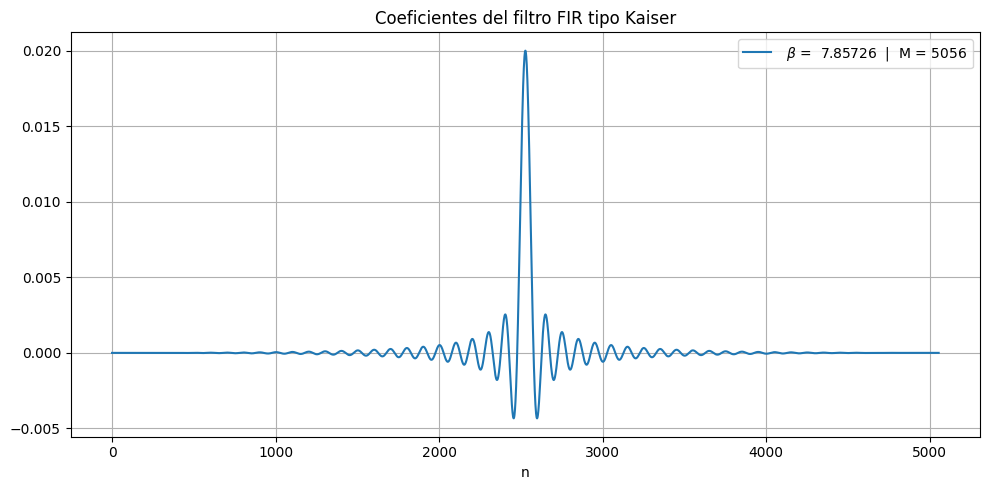

In [6]:
# Graficamos los coeficientes del filtro
plt.figure(figsize=(10, 5))
plt.plot(h_kaiser, label=' $β$ =  7.85726  |  M = 5056')
plt.title("Coeficientes del filtro FIR tipo Kaiser")
plt.xlabel("n")
plt.grid('on')
plt.legend()
plt.tight_layout()
plt.show()

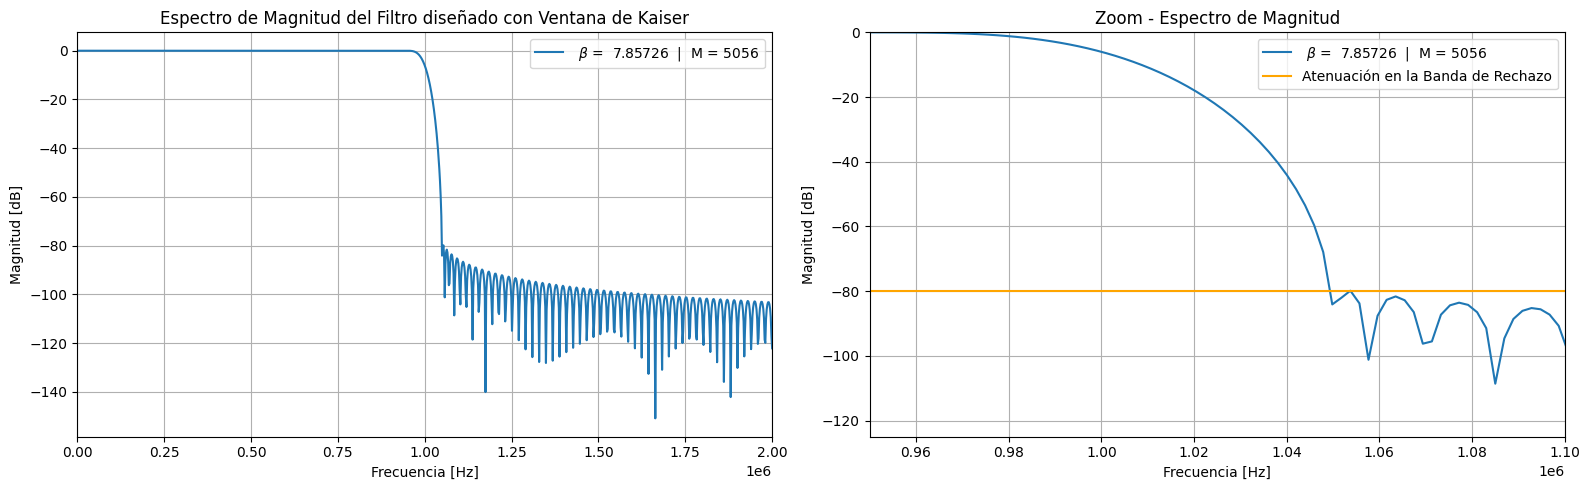

In [7]:
# Graficamos la respuesta en frecuencia - Espectro de Magnitud del filtro
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.plot(freq, H_kaiser_dB, label=' $β$ =  7.85726  |  M = 5056')
ax1.set_title("Espectro de Magnitud del Filtro diseñado con Ventana de Kaiser")
ax1.set_ylabel("Magnitud [dB]")
ax1.set_xlabel("Frecuencia [Hz]")
ax1.set_xlim([0,2e6])
ax1.legend()
ax1.grid('on')

ax2.plot(freq, H_kaiser_dB, label=' $β$ =  7.85726  |  M = 5056')
plt.axhline(y=-80, color='orange', linestyle='-', label='Atenuación en la Banda de Rechazo')
ax2.set_title("Zoom - Espectro de Magnitud")
ax2.set_ylabel("Magnitud [dB]")
ax2.set_xlabel("Frecuencia [Hz]")
ax2.set_xlim([0.95e6,1.1e6])
ax2.set_ylim([-125,0])
ax2.legend()
ax2.grid('on')

plt.tight_layout()
plt.show()

> El gráfico de la respuesta en frecuencia del filtro FIR demuestra cómo el filtro modula las diferentes frecuencias de la señal de entrada. Siendo un filtro pasa bajo, se observa una sección plana alrededor de 0 dB hasta la frecuencia de corte. Luego de esta frecuencia, la magnitud empieza a decrecer, lo que sugiere que las frecuencias fuera de la banda de paso son atenuadas. La región de transición revela una disminución progresiva de la magnitud.

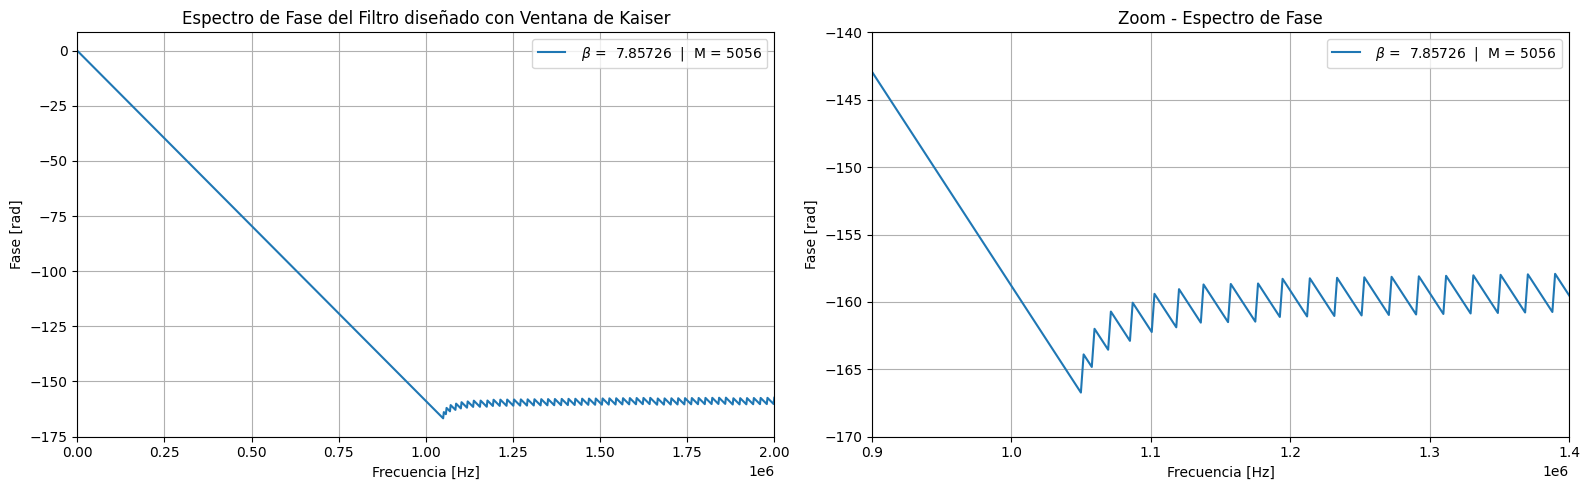

In [8]:
# Graficamos la respuesta en frecuencia - Espectro de Fase del filtro
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.plot(freq, H_kaiser_phase, label=' $β$ =  7.85726  |  M = 5056')
ax1.set_title("Espectro de Fase del Filtro diseñado con Ventana de Kaiser")
ax1.set_ylabel("Fase [rad]")
ax1.set_xlabel("Frecuencia [Hz]")
ax1.set_xlim([0,2e6])
ax1.legend()
ax1.grid('on')

ax2.plot(freq, H_kaiser_phase, label=' $β$ =  7.85726  |  M = 5056')
ax2.set_title("Zoom - Espectro de Fase")
ax2.set_ylabel("Fase [rad]")
ax2.set_xlabel("Frecuencia [Hz]")
ax2.set_xlim([0.9e6,1.4e6])
ax2.set_ylim([-170,-140])
ax2.legend()
ax2.grid('on')

plt.tight_layout()
plt.show()

> El gráfico de la fase del filtro FIR con ventana de Kaiser diseñado muestra una fase lineal en la banda de paso, lo que indica que el filtro mantiene la integridad de la fase de las componentes frecuenciales de la señal dentro de la banda de paso, luego de la banda de paso se observa un comportamiento discontinuo y muy atenuado lo que señala la reducción de las otras frecuencias de la señal que caen fuera de la banda de paso (banda de rechazo).

In [9]:
# Obtenemos los parámetros importantes del filtro diseñado

#======= Banda de Transición =======#
passband_edge = w[(H_kaiser_dB > 0) & (H_kaiser_dB < 0.7e-4)][-1]
stopband_edge = np.min(w[(w > 1.0475e6) & (w < 1.1e6)])
transition_band = np.abs(stopband_edge - passband_edge)

#======= Rizado en la Banda de Paso =======#
passband_max_ripple = np.max(H_kaiser_dB[(w >= 0) & (w <= f_cutoff-0.25e6)])
passband_min_ripple = np.min(H_kaiser_dB[(w >= 0) & (w <= f_cutoff-0.25e6)])
ripple_passband = np.abs(passband_min_ripple-passband_max_ripple)

#======= Rizado en la Banda de Rechazo =======#
stopband_max_ripple = np.max(H_kaiser_dB[w >= 1.0525e6])
stopband_min_ripple = np.min(H_kaiser_dB[w >= 1.0525e6])
ripple_stopband = np.abs(stopband_min_ripple-stopband_max_ripple)

print('======= Banda de Transición =======')
print(f"Ancho de la Banda de Transición: {transition_band}")
print(f"Frecuencia Inicial de Transición: {passband_edge}")
print(f"Frecuencia de Corte del Filtro: {f_cutoff}")
print(f"Frecuencia Final de Transición: {stopband_edge}")

print('======= Banda de Paso =======')
print(f"Rizado de la Banda de Paso: {ripple_passband}")

print('======= Banda de Rechazo =======')
print(f"Rizado de la Banda de Rechazo: {ripple_stopband}")

======= Banda de Transición =======
Ancho de la Banda de Transición: 105571.84750733152
Frecuencia Inicial de Transición: 942326.4907135875
Frecuencia de Corte del Filtro: 1000000.0
Frecuencia Final de Transición: 1047898.338220919
======= Banda de Paso =======
Rizado de la Banda de Paso: 0.000292183498588291
======= Banda de Rechazo =======
Rizado de la Banda de Rechazo: 71.00841734997553


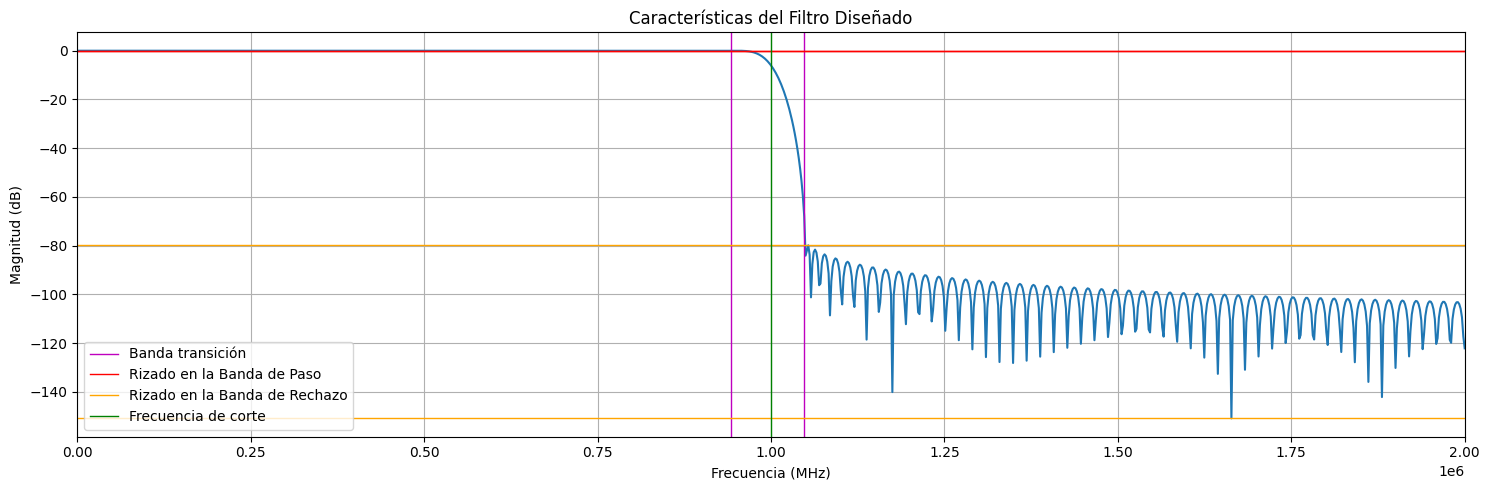

In [10]:
# Graficamos la respuesta en frecuencia y los parámetros del Filtro
plt.figure(figsize=(15, 5))
plt.plot(w, H_kaiser_dB)
plt.title('Características del Filtro Diseñado')
plt.xlabel('Frecuencia (MHz)')
plt.ylabel('Magnitud (dB)')
plt.xlim([0,2e6])

plt.axvline(x=passband_edge, color='m', linewidth=1, label='Banda transición')
plt.axvline(x=stopband_edge, color='m', linewidth=1)

plt.axhline(y=passband_max_ripple, color='r', linewidth=1, label='Rizado en la Banda de Paso')
plt.axhline(y=passband_min_ripple, color='r', linewidth=1,)

plt.axhline(y=stopband_max_ripple, color='orange', linewidth=1, label='Rizado en la Banda de Rechazo')
plt.axhline(y=stopband_min_ripple, color='orange', linewidth=1)

plt.axvline(x=f_cutoff, color='green', linewidth=1, label='Frecuencia de corte')

plt.grid('on')
plt.legend()
plt.tight_layout()
plt.show()

| Parámetro                        |         Valor   |
| :------------------------------- | :-------------: |
| Ancho de la Banda de Transición  |   105.571 KHz   |
| Frecuencia Inicial de Transición |   0.94232 MHz   |
| Frecuencia de Corte del Filtro   |   1 MHz         |
| Frecuencia Final de Transición   |   1.0478 MHz    |
| Rizado de la Banda de Paso       |   0.0002921 dB  |
| Rizado de la Banda de Rechazo    |   71.008417 dB  |

> Sobre esta parte se pudo observar claramente que al incrementar M se consigue aumentar el orden del filtro FIR lo que o ofrece una respuesta en frecuencia que se ajusta más precisamente a la deseada y es más precisa con los parámetros que deseamos modelar para el filtro, si incrementaramos M mucho más mejorará la banda de transición entre las bandas de paso y rechazo haciendose más estrecha y cortando más rápidamente las frecuencias que salen del rango deseado. Algunas conclusiones rápidas son:
> - Al incrementar M, la banda de transición (el área entre las bandas de paso y rechazo) se estrecha.
> - Con un valor de M más alto, el filtro tiene una mayor resolución en frecuencia. Esto significa que puede diferenciar mejor entre frecuencias cercanas, permitiendo transiciones más claras entre las bandas.
> - Cuanto mayor sea el orden del filtro, mejores serán los resultados. Un filtro de mayor orden se aproxima más al comportamiento ideal deseado.

2. Una técnica muy usada para este tipo de aplicaciones consiste en el uso de filtros tipo CIC (Cascade integrator comb filter). Considerando el esquema de filtrado siguiente, diseñe el filtro FIR compensador tal que cumpla con los criterios de diseño de la parte 1

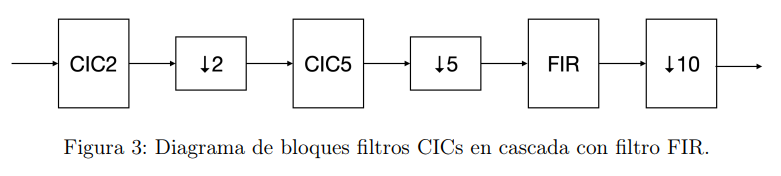

Tenga en cuenta que $H_{CIC2}(z) = \left( \frac{1 - z^{-2}}{1 - z^{-1}} \right)^2$  y  $H_{CIC5}(z) = \left( \frac{1 - z^{-5}}{1 - z^{-1}} \right)^5$

> Se debe diseñar el filtro FIR compensador para los filtros CIC solicitados, las funciones de transferencia brindadas en el enunciado pertenecen al dominio Z, antes de implementar el diseño se deben obtener esas respuestas en el dominio de la frecuencia.

> Considerando que un filtro CIC genérico tiene la siguiente función de transferencia:
> $$ H_{CIC}(z) = \left( \frac{1 - z^{-M}}{1 - z^{-1}} \right)^M $$ 
> 
>Además sabemos que la relación entre $z$ y $\omega$ es $$ \quad z = e^{j\omega} \quad z^{-1} = e^{-j\omega} $$
> Realizamos la siguiente conversión de las funciones de transferencia de los filtros CIC al dominio de la frecuencia:
> $$ \quad H_{CIC}(e^{j\omega}) = \left( \frac{1 - e^{-jM\omega}}{1 - e^{-j\omega}} \right)^M $$
>
> $$ \begin{align*} 1 - e^{-jM\omega} &= 1 - \cos(M\omega) + j\sin(M\omega) \\ 1 - e^{-j\omega} &= 1 - \cos \omega) + j\sin(\omega) \end{align*} $$
> $$ \left| H_{CIC}(e^{j\omega}) \right| = \left| \frac{1 - \cos(M\omega) + j\sin(M\omega)}{1 - \cos(\omega) + j\sin(\omega)} \right| $$
> $$ \left| H_{CIC}(e^{j\omega}) \right| = \sqrt{\frac{(1 - \cos(M\omega))^2 + \sin^2(M\omega)}{(1 - \cos(\omega))^2 + \sin^2(\omega)}} $$
> $$ \left| H_{CIC}(e^{j\omega}) \right| = \sqrt{\frac{1 - 2\cos(M\omega) + \cos^2(M\omega) + \sin^2(M\omega)}{2(1 - \cos(\omega))}} $$
> $$ \left| H_{CIC}(e^{j\omega}) \right| = \sqrt{\frac{1 - 2\cos(M\omega) + 1}{2(1 - \cos(\omega))}} $$
> $$ \left| H_{CIC}(e^{j\omega}) \right| = \frac{2\sin\left( \frac{M\omega}{2} \right)}{2\sin\left( \frac{\omega}{2} \right)} \Rightarrow \left| H_{CIC}(e^{j\omega}) \right| = \left( \frac{\sin\left( \frac{M\omega}{2} \right)}{\sin\left( \frac{\omega}{2} \right)} \right)^M$$

> Ambas funciones de transferencia quedarían como:
>$$\left| H_{CIC_2}(e^{j\omega}) \right| = \left( \frac{\sin\left( \omega \right)}{\sin\left( \frac{\omega}{2} \right)} \right)^2$$
> $$\left| H_{CIC_5}(e^{j\omega}) \right| = \left( \frac{\sin\left( \frac{5\omega}{2} \right)}{\sin\left( \frac{\omega}{2} \right)} \right)^5$$

> Procedemos a definir ambos filtros CIC ahora que están como respuestas en el dominio de la frecuencia

In [11]:
# Filtros CIC
def CIC2(w):
    return (np.sin(w) / np.sin(w / 2)) ** 2

def CIC5(w):
    return (np.sin(5 * w / 2) / np.sin(w / 2)) ** 5

> Definimos nuevamente los parámetros de diseño del filtro que permanecen para este nuevo diseño

In [12]:
# Parámetros de diseño

As = 80 # Atenuación en la banda de rechazo en dB
fs_init = 100e6 # Frecuencia de muestreo inicial (100 MHz)
fs_decimated = 1e6 # Frecuencia de muestreo después de la decimación (1 MHz)
f_cutoff = 1e6  # Frecuencia de corte (1 MHz)
delta_f = 0.1 * fs_decimated # Ancho de banda de transición (10% de la frecuencia de muestreo)

beta = signal.kaiser_beta(As)  # Beta para la ventana de Kaiser
M = int(np.ceil((As - 8) / (2.285 * (delta_f / fs_init))))

> Ahora generaremos la respuesta del arreglo solicitado, para ello usaremos ambos CIC y un nuevo FIR tipo Kaiser que funcionará como compensador.

In [13]:
# Generamos las respuestas en frecuencia de ambos filtros CIC
w = np.linspace(0.01, np.pi, num=8000)

H_CIC2 = CIC2(w)
H_CIC5 = CIC5(w)

# Combinamos ambas respuestas para colocar los filtros CIC en cascada
H_CIC_Cascade = H_CIC2*H_CIC5

# FIR compensador con Kaiser
h2 = signal.firwin(M, f_cutoff / (fs_init / 2), window=('kaiser', beta), pass_zero='lowpass')

# Respuesta en frecuencia del filtro FIR compensador (Parte 2)
w2, H_FIR = signal.freqz(h2, worN=8000)
f2 = w2 * fs_init / (2 * np.pi)

# Obtenemos la respuesta en frecuencia del sistema combinado solicitado
H_CIC_FIR = H_CIC_Cascade * H_FIR

# Normalizamos la frecuencia para que el filtro quede alineado a la frecuencia de corte
H_CIC_FIR = H_CIC_FIR / np.max(np.abs(H_CIC_FIR))

# Separamos la respuesta en frecuencia obtenida en magnitud y fase para graficar
H_CIC_FIR_dB = 20 * np.log10(abs(H_CIC_FIR))
H_CIC_FIR_phase = np.unwrap(np.angle(H_CIC_FIR))

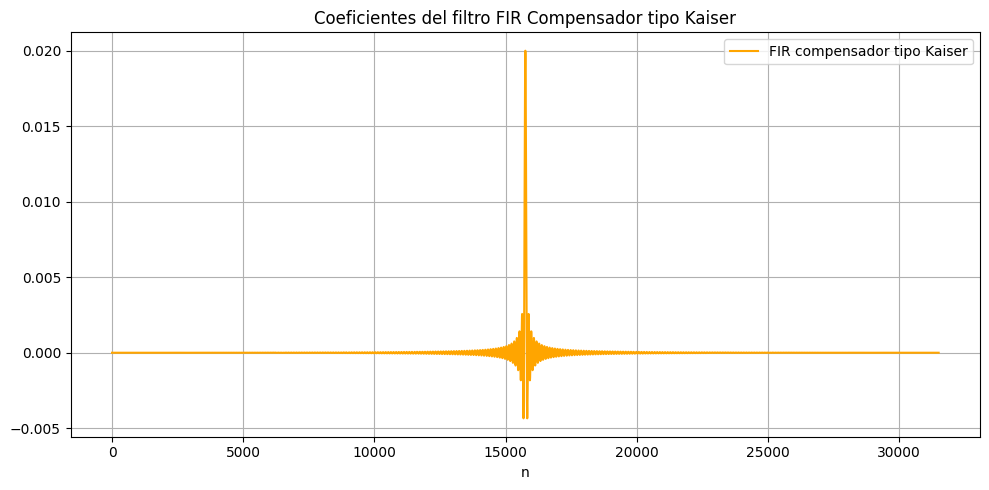

In [14]:
# Graficamos los coeficientes del filtro compensador
plt.figure(figsize=(10, 5))

plt.plot(h2, 'orange', label='FIR compensador tipo Kaiser')
plt.title("Coeficientes del filtro FIR Compensador tipo Kaiser")
plt.xlabel("n")
plt.grid('on')
plt.legend()
plt.tight_layout()
plt.show()

> Tambien vamos a graficar las respuestas en magnitud y fase para el sistema total como en la parte anterior para finalmente realizar la comparación.

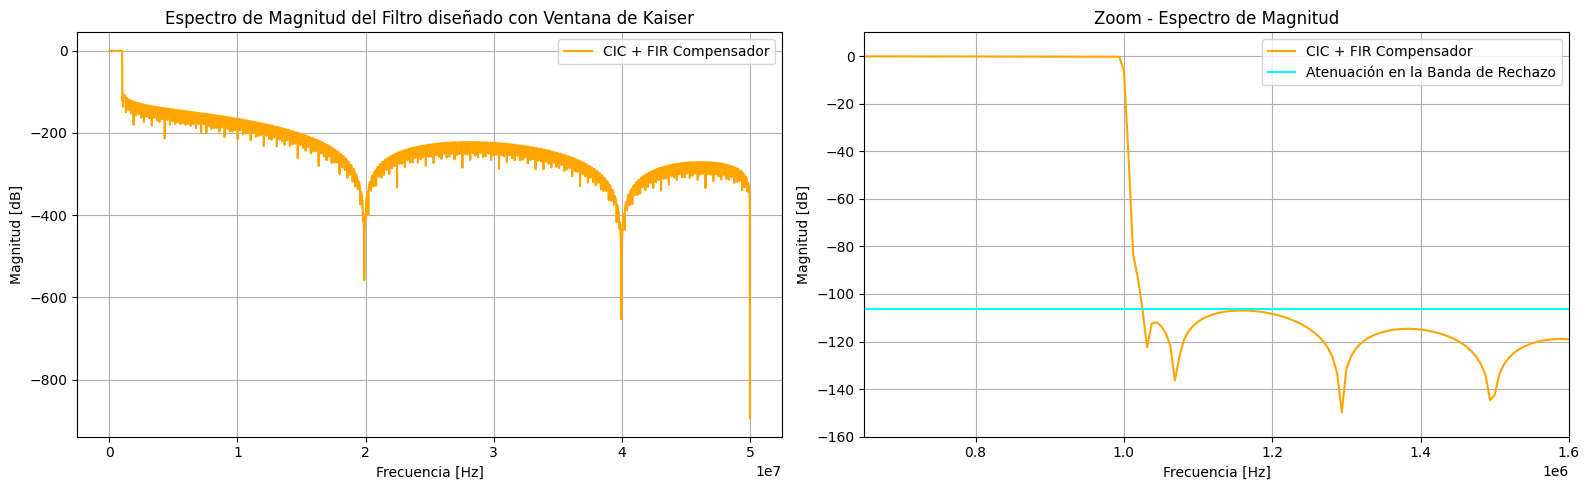

In [15]:
# Graficamos la respuesta en frecuencia - Espectro de Magnitud del filtro
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.plot(f2, H_CIC_FIR_dB, 'orange', label='CIC + FIR Compensador')
ax1.set_title("Espectro de Magnitud del Filtro diseñado con Ventana de Kaiser")
ax1.set_ylabel("Magnitud [dB]")
ax1.set_xlabel("Frecuencia [Hz]")
ax1.legend()
ax1.grid('on')

ax2.plot(f2, H_CIC_FIR_dB, 'orange', label='CIC + FIR Compensador')
plt.axhline(y=-106.5, color='cyan', linestyle='-', label='Atenuación en la Banda de Rechazo')
ax2.set_title("Zoom - Espectro de Magnitud")
ax2.set_ylabel("Magnitud [dB]")
ax2.set_xlabel("Frecuencia [Hz]")
ax2.set_xlim([0.65e6,1.6e6])
ax2.set_ylim([-160,10])
ax2.legend()
ax2.grid('on')

plt.tight_layout()
plt.show()

> En el espectro de magnitud observamos lo esperado para un filtro pasabajos, no hay atenuacion en la banda de paso y a partir de la frecuencia de corte crece abruptamente la atenuación. Además, se pueden observar varias caídas pronunciadas en la magnitud, que corresponden a los puntos nulos en la respuesta en frecuencia. Estos puntos nulos son una característica inherente de los filtros CIC y se producen en múltiplos de las frecuencias de aliasing generadas por los decimadores necesarios en el diseño. A simple vista este filtro tiene una mejor caida que el filtro del diseño anterior.

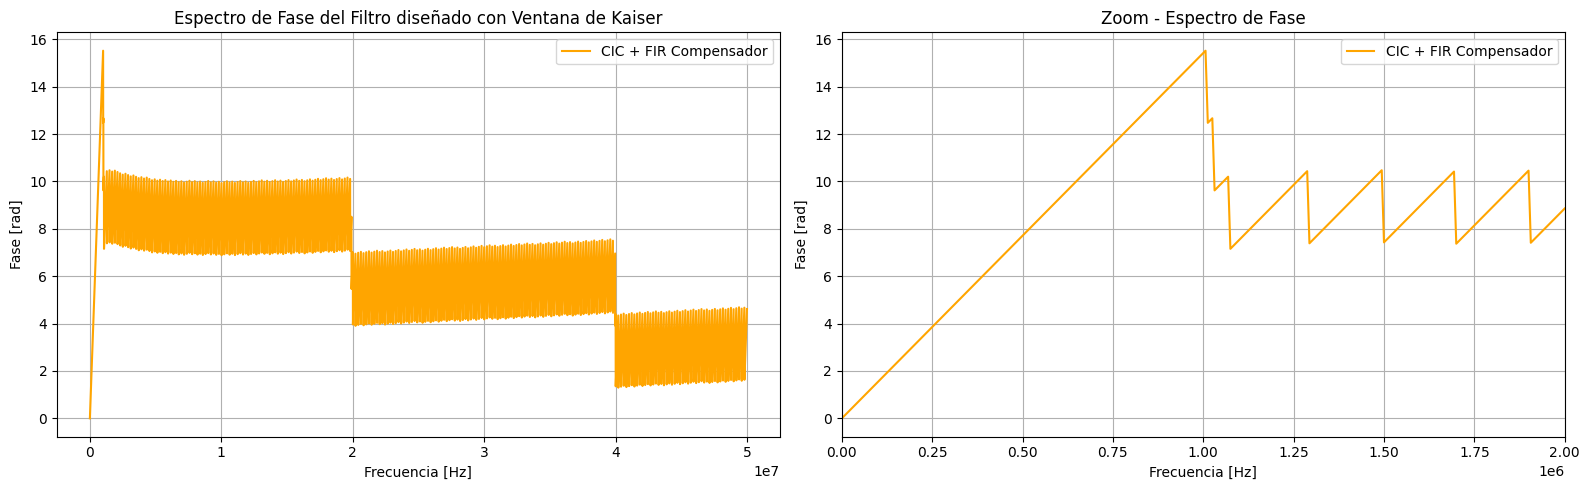

In [16]:
# Graficamos la respuesta en frecuencia - Espectro de Fase del filtro
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.plot(f2, H_CIC_FIR_phase, 'orange', label='CIC + FIR Compensador')
ax1.set_title("Espectro de Fase del Filtro diseñado con Ventana de Kaiser")
ax1.set_ylabel("Fase [rad]")
ax1.set_xlabel("Frecuencia [Hz]")
ax1.legend()
ax1.grid('on')

ax2.plot(f2, H_CIC_FIR_phase, 'orange', label='CIC + FIR Compensador')
ax2.set_title("Zoom - Espectro de Fase")
ax2.set_ylabel("Fase [rad]")
ax2.set_xlabel("Frecuencia [Hz]")
ax2.set_xlim([0,2e6])
ax2.legend()
ax2.grid('on')

plt.tight_layout()
plt.show()

> Sobre su espectro de fase, nuevamente tiene un comportamiento lineal durante la banda de paso lo cual es un comportamiento muy deseado en filtros, pasando la frecuencia de corte la fase se comporta de forma discontinua y muy atenuada lo que señala la reducción de las otras frecuencias de la señal que caen fuera de la banda de paso (banda de rechazo).

In [17]:
# Filtro FIR utilizando la técnica de enventanado con ventana de Kaiser
h1 = signal.firwin(M, f_cutoff / (fs_init / 2), window=('kaiser', beta), pass_zero='lowpass')

# Respuesta en frecuencia del filtro FIR (Parte 1)
w1, H1 = signal.freqz(h1, worN=8000)
f1 = w1 * fs_init / (2 * np.pi)

# Normalizar la respuesta en frecuencia a 0 dB en la frecuencia de paso
H1 = H1 / np.max(np.abs(H1))

In [18]:
# Obtenemos los parámetros importantes del filtro diseñado

#======= Banda de Transición =======#
passband_edge = 0.99e6
stopband_edge = 1.025e6
transition_band = np.abs(stopband_edge - passband_edge)

#======= Rizado en la Banda de Paso =======#
passband_max_ripple = np.max(H_CIC_FIR_dB[(f2 >= 0) & (f2 <= f_cutoff-0.25e6)])
passband_min_ripple = np.min(H_CIC_FIR_dB[(f2 >= 0) & (f2 <= f_cutoff-0.25e6)])
ripple_passband = np.abs(passband_min_ripple-passband_max_ripple)

#======= Rizado en la Banda de Rechazo =======#
stopband_max_ripple = np.max(H_CIC_FIR_dB[f2 >= 1.0525e6])
stopband_min_ripple = np.min(H_CIC_FIR_dB[f2 >= 1.0525e6])
ripple_stopband = np.abs(stopband_min_ripple-stopband_max_ripple)

print('======= Banda de Transición =======')
print(f"Ancho de la Banda de Transición: {transition_band}")
print(f"Frecuencia Inicial de Transición: {passband_edge}")
print(f"Frecuencia de Corte del Filtro: {f_cutoff}")
print(f"Frecuencia Final de Transición: {stopband_edge}")

print('======= Banda de Paso =======')
print(f"Rizado de la Banda de Paso: {ripple_passband}")

print('======= Banda de Rechazo =======')
print(f"Rizado de la Banda de Rechazo: {ripple_stopband}")

======= Banda de Transición =======
Ancho de la Banda de Transición: 35000.0
Frecuencia Inicial de Transición: 990000.0
Frecuencia de Corte del Filtro: 1000000.0
Frecuencia Final de Transición: 1025000.0
======= Banda de Paso =======
Rizado de la Banda de Paso: 0.14358553910260385
======= Banda de Rechazo =======
Rizado de la Banda de Rechazo: 787.3658967059018


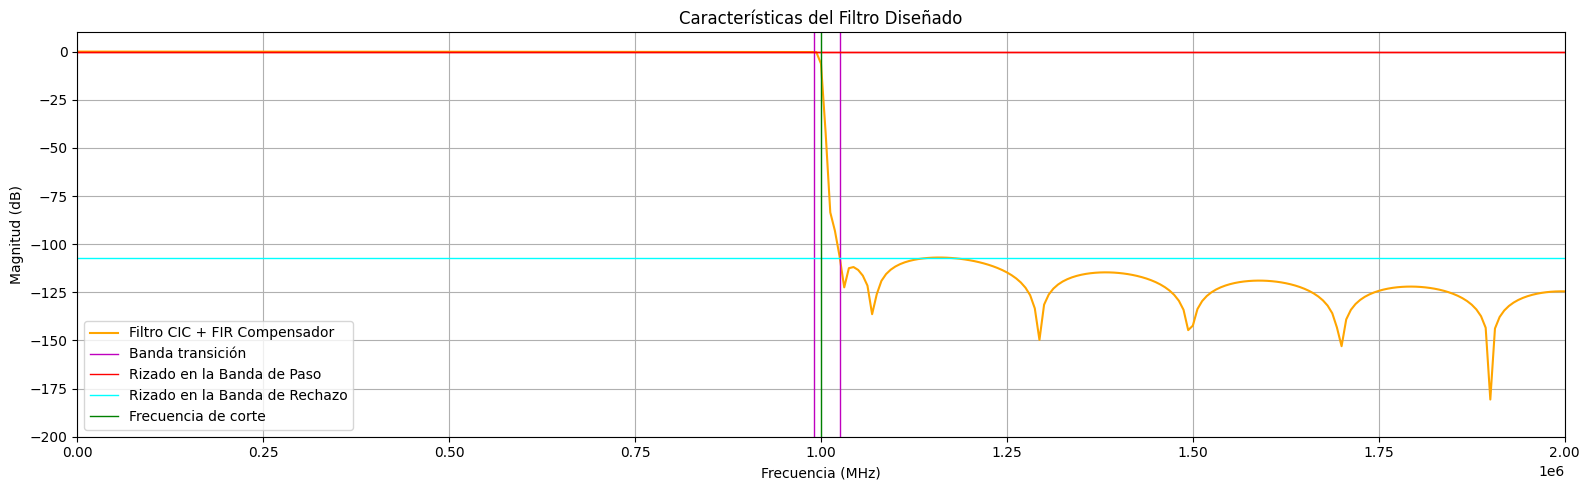

In [19]:
# Gráfica de los parámetros principales del filtro diseñado

plt.figure(figsize=(16, 5))
plt.plot(f2, H_CIC_FIR_dB, 'orange', label='Filtro CIC + FIR Compensador')
plt.title('Características del Filtro Diseñado')
plt.xlabel('Frecuencia (MHz)')
plt.ylabel('Magnitud (dB)')
plt.xlim(0, 2e6) 
plt.ylim(-200, 10) 

plt.axvline(x=passband_edge, color='m', linewidth=1, label='Banda transición')
plt.axvline(x=stopband_edge, color='m', linewidth=1)

plt.axhline(y=passband_max_ripple, color='r', linewidth=1, label='Rizado en la Banda de Paso')
plt.axhline(y=passband_min_ripple, color='r', linewidth=1,)

plt.axhline(y=stopband_max_ripple, color='cyan', linewidth=1, label='Rizado en la Banda de Rechazo')
plt.axhline(y=stopband_min_ripple, color='cyan', linewidth=1)

plt.axvline(x=f_cutoff, color='green', linewidth=1, label='Frecuencia de corte')


plt.grid('on')
plt.legend()
plt.tight_layout()
plt.show()

| Parámetro                        |         Valor   |
| :------------------------------- | :-------------: |
| Ancho de la Banda de Transición  |   35.000  KHz   |
| Frecuencia Inicial de Transición |   0.99000 MHz   |
| Frecuencia de Corte del Filtro   |   1 MHz         |
| Frecuencia Final de Transición   |   1.02500 MHz   |
| Rizado de la Banda de Paso       |   0.1435855 dB  |
| Rizado de la Banda de Rechazo    |   787.36589 dB  |

3. Finalmente, compare las respuestas en frecuencia de los filtros diseñados. Presente gráficos en los que compare las respuestas en frecuencia de los filtros diseñados en las partes 1 y 2 tanto en magnitud como en fase. Además, indique que filtro considera es el más adecuado para nuestra aplicación. Justifique su respuesta.

> Se compararán ambos filtros en el espectro de magnitud y en el espectro de frecuencia para analizar el comportamiento de cada uno y sus diferencias.

In [20]:
# Se volvió a generar el filtro de la primera parte para que coincida en espectro con el nuevo filtro diseñado a comparar.

# Parámetros de diseño para generar el Filtro
As = 80 # Atenuación en la banda de rechazo en dB
fs_init = 100e6 # Frecuencia de muestreo inicial (100 MHz)
fs_decimated = 1e6 # Frecuencia de muestreo después de la decimación (1 MHz)
f_cutoff = 1e6  # Frecuencia de corte (1 MHz)
delta_f = 0.1 * fs_decimated # Ancho de banda de transición (10% de la frecuencia de muestreo)

beta = signal.kaiser_beta(As)  # Beta para la ventana de Kaiser
M = int(np.ceil((As - 8) / (2.285 * (delta_f / fs_init))))

# Filtro FIR con ventana de Kaiser de la primera parte
h_kaiser1 = signal.firwin(M, f_cutoff / (fs_init / 2), window=('kaiser', beta), pass_zero='lowpass')

# Respuesta en frecuencia del filtro FIR tipo Kaiser
w1, H_kaiser1 = signal.freqz(h_kaiser1, worN=8000)
freq1 = w1 * fs_init / (2 * np.pi)

H_kaiser1_dB = 20 * np.log10(abs(H_kaiser1))
H_kaiser1_phase = np.unwrap(np.angle(H_kaiser1))

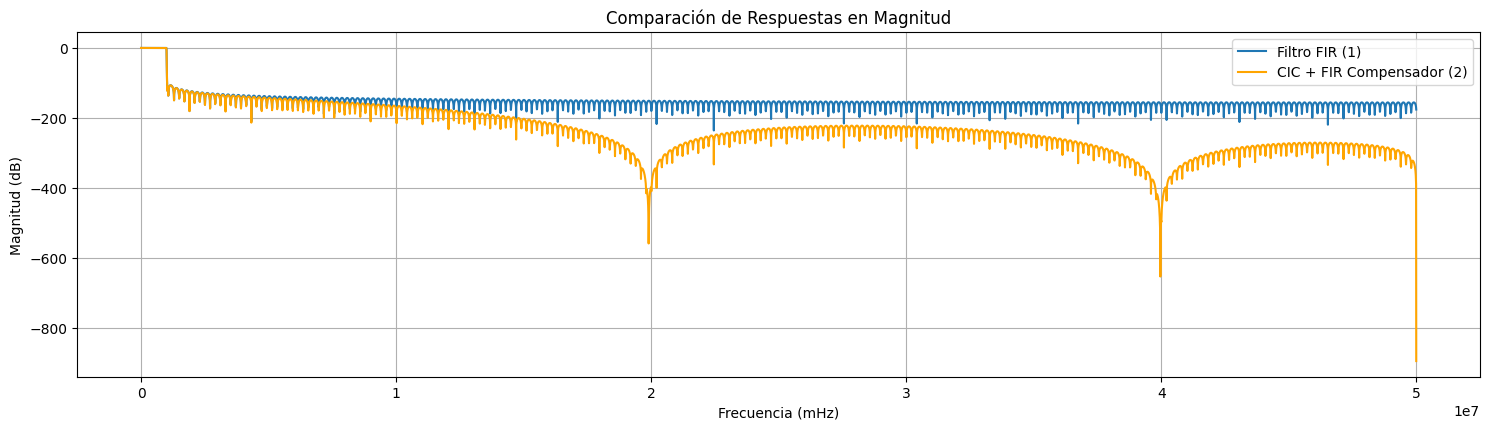

In [21]:
# Gráficos de comparación
plt.figure(figsize=(15, 8))

# Respuesta en magnitud
plt.subplot(2, 1, 1)
plt.plot(freq1, H_kaiser1_dB, label='Filtro FIR (1)')
plt.plot(f2, H_CIC_FIR_dB, 'orange', label='CIC + FIR Compensador (2)')
plt.title('Comparación de Respuestas en Magnitud')
plt.xlabel('Frecuencia (mHz)')
plt.ylabel('Magnitud (dB)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

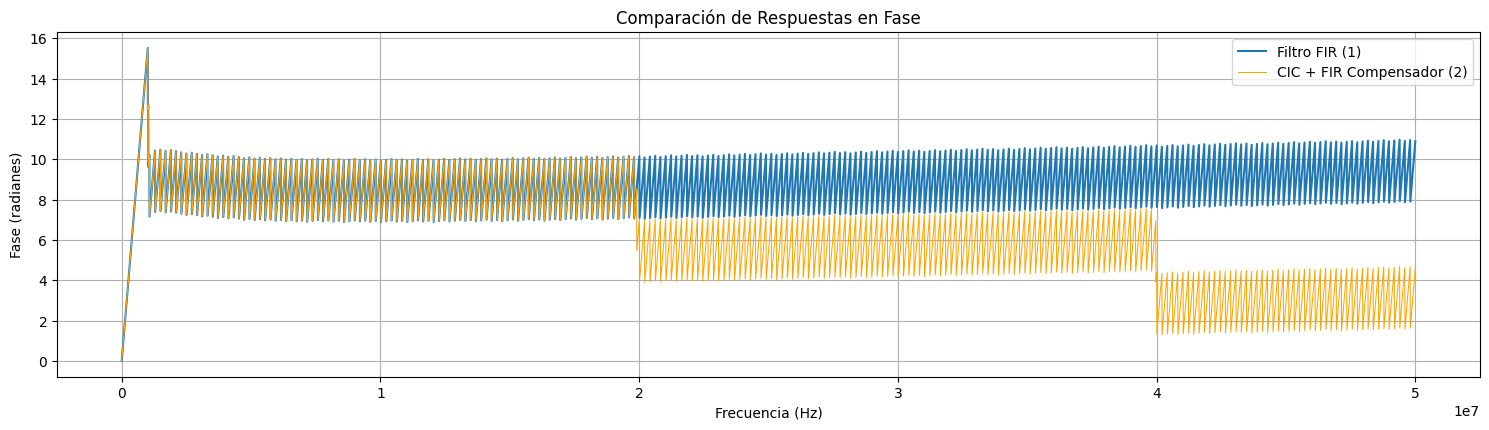

In [22]:
# Gráficos de comparación
plt.figure(figsize=(15, 8))

# Respuesta en fase
plt.subplot(2, 1, 2)
plt.plot(freq1, H_kaiser1_phase, label='Filtro FIR (1)')
plt.plot(f2, H_CIC_FIR_phase, 'orange', linewidth=0.75, label='CIC + FIR Compensador (2)')
plt.title('Comparación de Respuestas en Fase')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Fase (radianes)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

> **Conclusiones**
>
> Ambos filtros cumplen bastante bien el requerimiento solicitado sin embargo para determinar cual es la mejor opción hay que analizar ambos espectros, tanto en magnitud como en fase, en cuanto al espectro de magnitud, el primer diseño tiene una banda de transición algo grande en comparación al segundo diseño cuya banda de transición es mucho mas estrecha, el segundo diseño tambien tiene menor ondulación o rizado en la banda de paso, en la banda de rechazo ambos diseños atenuan bastante bien las frecuencias que pasan de la frecuencia de corte.
>
> Sobre el espectro de frecuencia, en ambos diseños la fase se comporta de forma lineal a lo largo de la banda de paso, luego de la banda de paso es verdad que el segundo diseño se comporta de forma distinta pero las frecuencias que caen en la banda de rechazo ya no interesan por lo que podriamos decir que ambos diseños se comportan igual para el espectro de fase.
>
> Analizando principalmente las diferencias en el espectro de magnitud podemos concluir que el segundo diseño atenúa más rapido las frecuencias que se pasan de la frecuencia de corte, además cuenta con un menor rizado en la banda de paso, si no consideramos la complejidad del diseño como un factor importante se puede afirmar que el segundo diseño es una mejor implementación del primer filtro FIR con ventana de Kaiser.

## 2. Espectrograma de señales aleatorias



Un policía se encuentra ubicado a 10 metros de una carretera recta con una pistola de radar controlando el tránsito de los vehículos. El sistema de radar transmite una señal de radio a una frecuencia $f_{rad}$ = 16 GHz y adquiere las señales de retorno (demoduladas en banda base) a una velocidad de muestreo $f_s$ = 10 kHz. Al ver un vehículo acercarse, el policía enciende el sistema y adquiere datos por un periodo de aproximadamente 10 segundos apuntando en todo momento directamente al vehículo. Los datos adquiridos (números complejos) se han almacenado en un archivo  data2024.csv" en formato texto.

1. Lea los datos del archivo "data2024.csv" y grafique la señal detectada por el radar en el dominio del tiempo t.

In [23]:
# Tenemos los siguientes datos
fs = 10e3 # frecuencia de muestreo
Ts = 1 / fs # tiempo de muestreo

# Leemos el archivo "data2024.csv", con la librería numpy extraemos los valores complejos
datafile = 'data2024.csv'
data = np.genfromtxt(datafile, delimiter=',', dtype=complex)

# Obtenemos el vector de tiempo de la longitud de muestras del archivo
n = len(data)
t = np.arange(n)*Ts

FileNotFoundError: data2024.csv not found.

In [ ]:
# Graficamos los coeficientes del filtro
plt.figure(figsize=(14, 5))
plt.plot(t, np.real(data), label=' Señal detectada por el Radar')
plt.title("Señal Detectada")
plt.xlabel("Tiempo (s)")
plt.grid('on')

plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

2. Genere y grafique el espectrograma (frecuencia vs. tiempo) de la señal de radar considerando que la señal se a dividido en bloques de 128 muestras cada uno. ¿Cómo interpreta que la frecuencia de la señal varié de un valor positivo a uno negativo?


In [ ]:
L = 128 # Longitud de cada segmento
M = n//L # Número de segmentos
tm = np.arange(M) * L / fs # Tiempos centrales de cada segmento
fk = (np.arange(L) - L/2) * fs / L # Frecuencias correspondientes a la FFT desplazada

# Inicialización de la matriz de periodogramas
Xperiodograma = np.zeros((M, L))

# Cálculo del periodograma para cada segmento
for m in range(M):
    xm = data[m*L:(m+1)*L]
    Xperiodograma[m, :] = np.abs(np.fft.fft(xm))**2 / L

Xper = np.fft.fftshift(Xperiodograma, axes=1)
Xper_log = 10 * np.log10(Xper)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


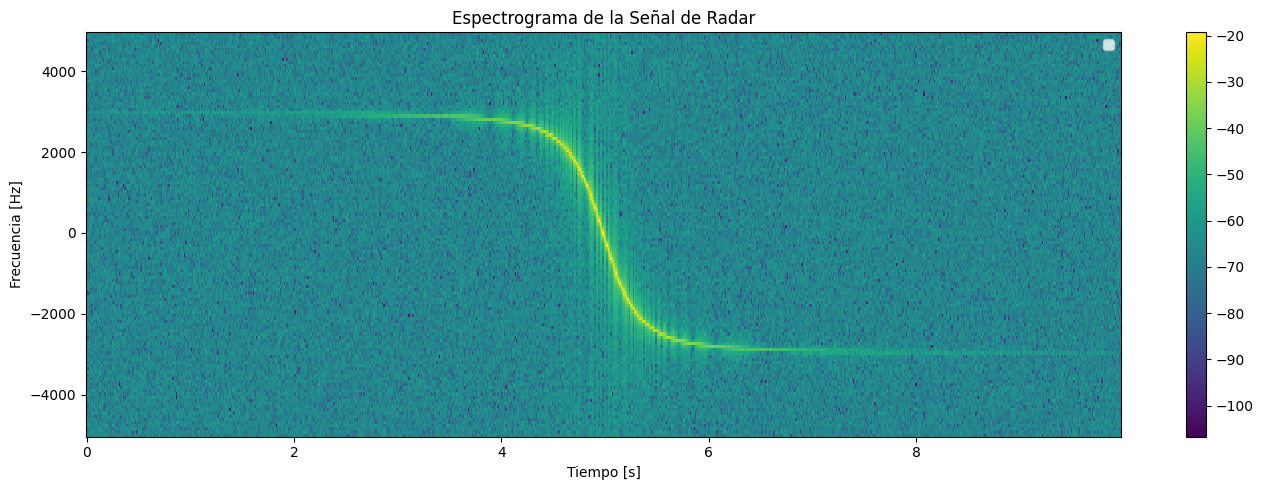

In [ ]:
# Graficamos el espectrograma generado
fig = plt.figure(figsize=(14, 5))

plt.title('Espectrograma de la Señal de Radar')
c = plt.pcolormesh(tm, fk, Xper_log.T, shading='auto')
plt.xlabel('Tiempo [s]')
plt.ylabel('Frecuencia [Hz]')
plt.colorbar(c)

plt.legend()
plt.tight_layout()
plt.show()

> Según el esceenario descrito en el enunciado, el policía utiliza una pistola dee radar para la medición de velocidad de vehículos que pasan por la carretera, el radar funciona emitiendo una señal de radio a una frecuencia de 16 GHz y capta las señales que retornan a una velocidad de muestreo de 10 kHz. La explicación de porque la frecuencia comienza siendo positiva, y termina siendo negativa recae en el efecto Doppler.
>
> El efecto Doppler describe el cambio en la frecuencia de una onda cuando la fuente (vehículo a velocidad) y el observador (radar del policía) están en movimiento relativo, es decir uno se mueve respecto del otro. Si el behículo se mueve hacia el radar, la frecuencia de la señal reflejada será mayor que la frecuencia emitida, si el vehículo se aleja la frecuencia reflejada será menor.
>
> En conclusión para cerrar la idea, si observamos en el periodograma que primero la frecuencia es positiva se debe a que el vehículo se está acercando al radar, en esta situación la frecuencia reflejada es mayor que la frecuencia emitida debido al efecto Doppler. Cuando el periodograma evoluciona con el tiempo y la frecuencia pasa a ser negativa corresponde al lapso en el que el vehículo se esta alejando lo que provoca dicha disminución de la frecuencia de la señal reflejada. 
> 
> Finalmente, también se observa que la evolución de la frecuencia es simétrica es porque probablemente durante el registro del radar el auto iba a una velocidad constante por lo que la frecuencia de rebote al acercarse era de la misma proporcion que la registrada cuando se alejaba.

3. La desviación en frecuencia de la señal que mide el radar fD es igual a la proyección de la
velocidad del objeto detectado (velocidad radial vr) dividida por la mitad de la longitud de onda de la señal que transmite el radar (λrad), es decir,

$$ f_D = \left( \frac{v_r}{\lambda _{rad} / 2} \right) $$

Dada esta relación, ¿cuál es la velocidad a la que viajaba el vehículo detectado por el radar?

> Como se analizó el efecto Doppler está presente en este caso, la frecuencia de Doppler se puede calcular utilizando la siguiente fórmula:
>
> $$ f_D = \left( \frac{2v . f_{rad}}{c} \right) $$
> - $v$ es la velocidad del vehículo.
> - $f_{rad}$ es la frecuencia de la señal de radar emitida
> - $c$ es la velocidad de la luz
>
> La formula otorgada en el enunciado es una arreglo de esta formula donde $f_{rad}$ pasa a ser $\lambda _{rad}$ gracias a la relación entre la frecuencia y la longitud de una onda.
>
> Por lo tanto podemos calcular $\lambda _{rad}$ como $\frac{c}{f_{rad}}$

In [ ]:
# Calculamos lambda según lo explicado previamente
lambda_rad = 3e8/16e9

# Observamos en el periodograma que las frecuencias de interés van desde los -40
# Los valores centrales con mayor desviación en la intensidad se encuentran por encima de -40
min_intensidad = -40  

# Inicializamos un arreglo para las posibles frecuencias maximas
possible_freq = []

# Recorremos el periodograma para obtener la frecuencia máxima registrada
for m in range(M):
    possible_index = np.where(Xper_log[m, :] > min_intensidad)[0]
    if len(possible_index) > 0:
        max_freq_index = possible_index[-1] 
        possible_freq.append(fk[max_freq_index])
    else:
        possible_freq.append(0)

array_freq = np.array(possible_freq) # Lo transformamos en un arreglo de numpy

f_doppler = np.max(array_freq) # Hallamos la frecuencia de doppler máxima

vel_rad = f_doppler * (lambda_rad / 2) # Despejamos la fórmula y obtenemos la velocidad radial

print(f"Frecuencia de Doppler: {f_doppler} Hz")
print(f"Velocidad radial del vehículo (v_r): {vel_rad} m/s")

Frecuencia de Doppler: 2812.5 Hz
Velocidad radial del vehículo (v_r): 26.3671875 m/s


> Obtuvimos que la velocidad radial del vehículo registrado fue de aproximadamente 26.3671 m/s

4. Considere que la señal detectada por el radar pasa por un downsampler con factor M = 2. Genere y grafique el espectrograma de la señal decimada. ¿Se puede determinar correctamente la velocidad a la que viajaba el  vehículo? Justifique su respuesta.

> Para comprobar si es posible la aplicación del downsampler de factor M = 2 y seguir determinando correctamente la velocidad a la que viajaba el vehículo realizaremos el downsampling, graficaremos y evaluaremos.

In [ ]:
# Aplicamos el factor downsampling
D = 2

fs_downsampling = fs/D
data_downsampling = data[::D]
n_downsampling = len(data_downsampling)
t_downsampling = np.arange(n_downsampling)/fs_downsampling

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


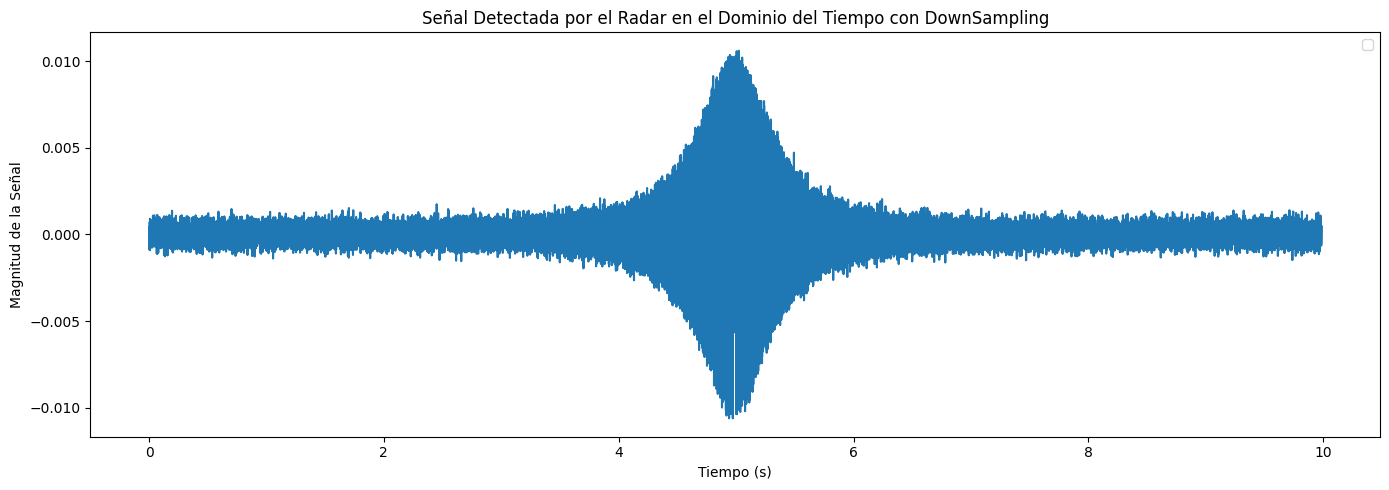

In [ ]:
# Graficamos la señal con el downsampling realizado
plt.figure(figsize=(14, 5))
plt.title('Señal Detectada por el Radar en el Dominio del Tiempo con DownSampling')
plt.plot(t_downsampling, np.real(data_downsampling))
plt.xlabel('Tiempo (s)')
plt.ylabel('Magnitud de la Señal')

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
L = 128 # Longitud de cada segmento
M_downsampling = n_downsampling//L # Número de segmentos
tm_downsampling = np.arange(M_downsampling) * L / fs_downsampling # Tiempos centrales de cada segmento
fk_downsampling = (np.arange(L) - L / 2) * fs_downsampling / L # Frecuencias correspondientes a la FFT desplazada

# Inicialización de la matriz de periodogramas
Xperiodograma_downsampling = np.zeros((M_downsampling, L))

# Cálculo del periodograma para cada segmento
for m in range(M_downsampling):
    xm_downsampling = data_downsampling[m * L:(m + 1) * L]
    Xperiodograma_downsampling[m, :] = np.abs(np.fft.fft(xm_downsampling))**2 / L

Xper_downsampling = np.fft.fftshift(Xperiodograma_downsampling, axes=1)
Xper_downsampling_log = 10 * np.log10(Xper_downsampling) 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


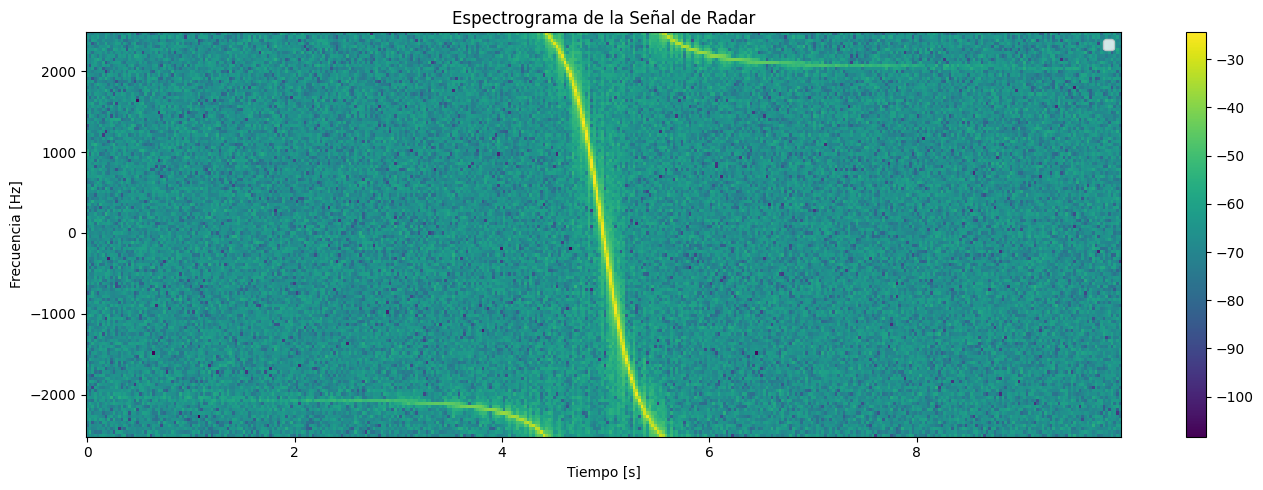

In [ ]:
# Graficamos el espectrograma generado
fig = plt.figure(figsize=(14, 5))

plt.title('Espectrograma de la Señal de Radar')
c = plt.pcolormesh(tm_downsampling, fk_downsampling, Xper_downsampling_log.T, shading='auto')
plt.xlabel('Tiempo [s]')
plt.ylabel('Frecuencia [Hz]')
plt.colorbar(c)

plt.legend()
plt.tight_layout()
plt.show()

> Cuando se realiza el downsampling de la muestra claramente observamos que en el periodograma se aprecia el Aliasing generado por el downsampling realizado, esto sucede pues see reduce la frecuencia de muestreo lo que provoca un fallo en el criterio de Nyquist.
>
> El Aliasing generado por el downsampling impide el correcto registro de altas frecuencias ya que estas adoptan una posición reflejada por el efecto de rebote en el periodograma, ya que no se pueden determinar adecuadamente las altas frecuencias, no se podría determinar adecuadamente la máxima desviación de frecuencia que es lo necesario para calcular la velocidad del vehículo, por tanto, no se podría determinar la velocidad una vez realizado el downsampling.

## 3. Cancelador de ruido


En este problema vamos a aplicar las técnicas aprendidas en el curso para el filtrado de ruido
de señales discretas. Primero considere el diagrama de cancelación de ruido de la siguiente figura.


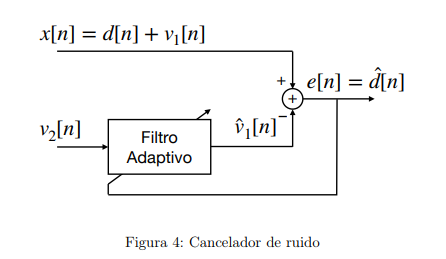

En este caso vamos a considerar que la señal deseada d[n] es una señal sinusoidal

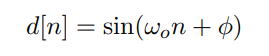

donde ωo = π/8 y ϕ = 0, además, las secuencias de ruido v1[n] y v2[n] son procesos AR(1) cuyas
ecuaciones de diferencias son

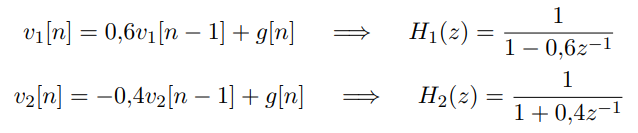

donde g[n]es ruido blanco gaussiano con varianza igual a uno.
En este problema vamos a analizar la performance del filtro Wiener y el algoritmo LMS para
remover el ruido de la señal observada.


1. Primero vamos a analizar la performance del filtro Wiener para diferentes valores de longitud del filtro M, para lo cual calculamos el error medio cuadrático entre la señal deseada d[n] y la estimada ˆd[n]. Prepare una tabla del error medio cuadrático para longitudes M = 2, 4, 8, 16, 32, 64, 128 y presente gráficos de los coeficientes del filtro estimado en cada caso. ¿En qué caso se obtiene el menor error cuadrático? ¿Cómo varían los coeficientes del filtro Wiener conforme aumenta M? ¿Por qué incrementa ligeramente el error para valores muy largos de M, como se relaciona este comportamiento con los coeficientes del filtro? Justifique sus respuestas.

> Primero generaremos la señal detectada por el cancelador de ruido con los parámetros dados por el enunciado

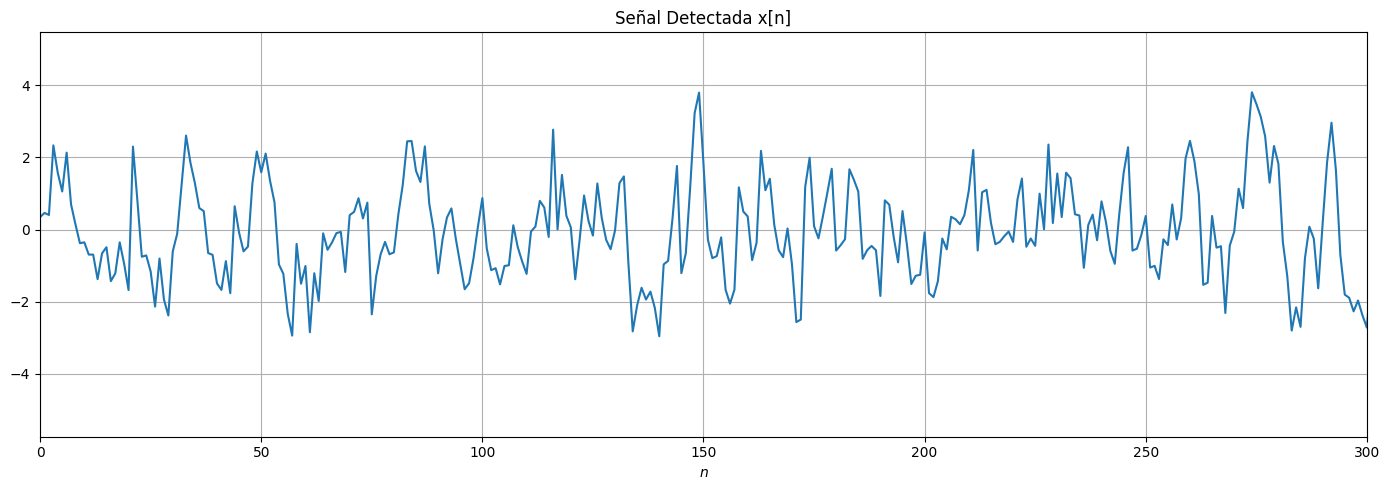

In [ ]:
# Generamos la señal detectada
N = 5000

# Generamos la señal deseada d[n]
n = np.arange(N)
dn = np.sin(np.pi/8*n)

# Generamos el Ruido blanco gaussiano
gn = np.random.randn(N)

# Generamos las dos señales de ruido autoregresivo AR(1).
alpha1 = 0.6
v1 = signal.lfilter([1],[1,-alpha1],gn)
alpha2 = -0.4
v2 = signal.lfilter([1],[1,-alpha2],gn)

# La señal observada será d + v1
x = dn + v1

# Graficamos la señal con el downsampling realizado
plt.figure(figsize=(14, 5))
plt.title('Señal Detectada x[n]')
plt.plot(x)
plt.xlim([0,300])
plt.xlabel('$n$')

plt.grid('on')
plt.tight_layout()
plt.show()

Dado que estamos evaluando primero el filtro Wiener, necesitamos calcular las matrices de autocorrelación y el vector de correlación cruzada para determinar los coeficientes en cada situación. Nos enfocamos en la autocorrelación y la correlación cruzada según la teoría:

$$r_x[k] = E({ x[n]x[n − k] })$$
$$r_{dx}[k] = E{(d[n]x[n − k])}$$

In [ ]:
errores_cuadraticos = []

### M = 2

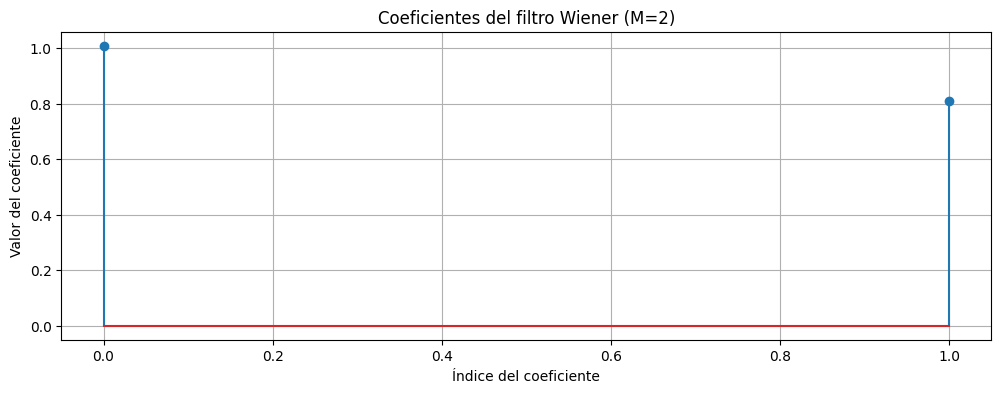

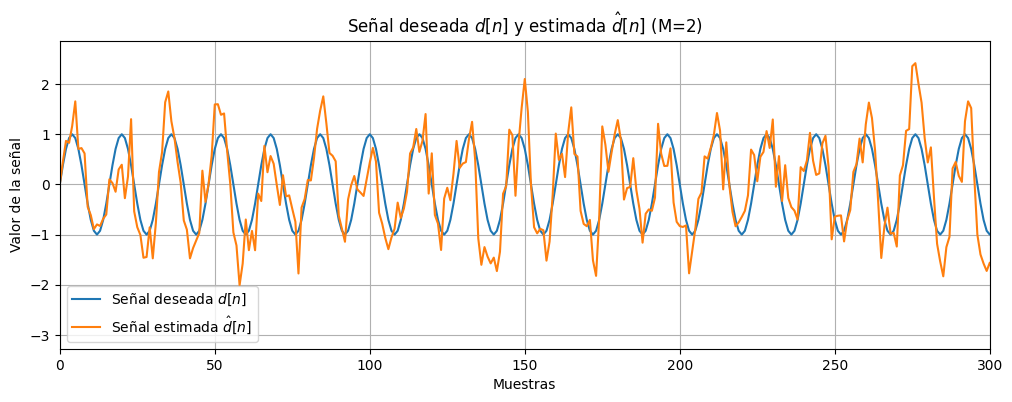

Error cuadrático medio para M=2: 0.3549451107421771


In [ ]:
# Definición del orden del filtro Wiener
M = 2

# Generamos la matriz de autocorrelaciones
R_v2 = np.zeros((M, M))
for i in range(M):
    for j in range(M):
        # Hallamos las autocorrelaciones, usamos la función np.mean para hallar
        # la esperanza. Entonces podemos calcular la autocorrelación como la formula
        R_v2[i, j] = np.mean(v2[np.abs(i - j):N] * v2[:N - np.abs(i - j)])

# Obtenemos el vector de correlación cruzada r_x_v2
r_x_v2 = np.zeros(M)
for k in range(M):
    # Hallamos la correlación cruzada
    r_x_v2[k] = np.mean(x[k:N - 1] * v2[0:N - (k + 1)])

# Cálculo de los coeficientes del filtro Wiener
W = np.dot(np.linalg.inv(R_v2), r_x_v2)
v1_estimado = signal.lfilter(W,[1],v2)

# Hallamos el error o d[n] estimado
error = x - v1_estimado
d_estimado = error

# Calculamos el error cuadrático medio
error_cuadratico = np.mean((dn[M:]-d_estimado[M:])**2)

# Visualización de los coeficientes del filtro Wiener
plt.figure(figsize=[12, 4])
plt.stem(W)
plt.title(f"Coeficientes del filtro Wiener (M={M})")
plt.xlabel('Índice del coeficiente')
plt.ylabel('Valor del coeficiente')
plt.grid('on')
plt.show()

# Visualización de la señal deseada y la estimada
plt.figure(figsize=[12, 4])
plt.plot(dn, label='Señal deseada $d[n]$')
plt.plot(d_estimado, label='Señal estimada $\hat{d}[n]$')
plt.title('Señal deseada $d[n]$ y estimada $\hat{d}[n]$ (M=2)')
plt.xlabel('Muestras')
plt.ylabel('Valor de la señal')
plt.xlim([0, 300])
plt.legend()
plt.grid('on')
plt.show()

# Impresión del error cuadrático medio
print(f'Error cuadrático medio para M={M}: {error_cuadratico}')
errores_cuadraticos.append(error_cuadratico)

### M = 4

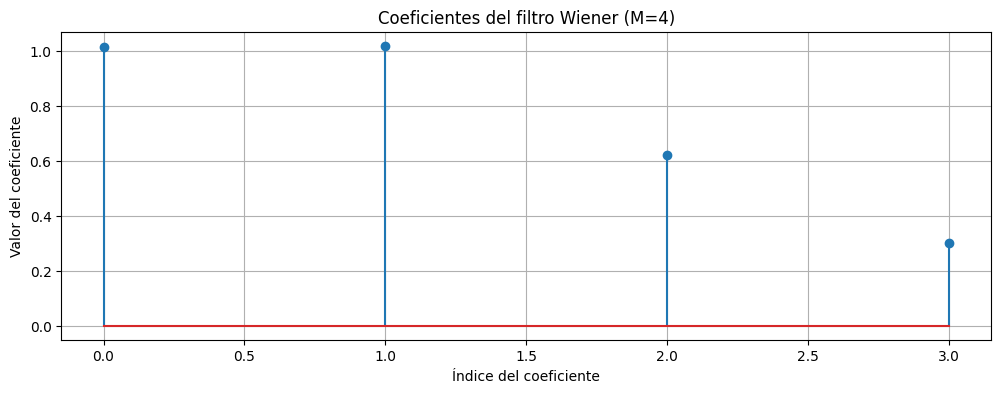

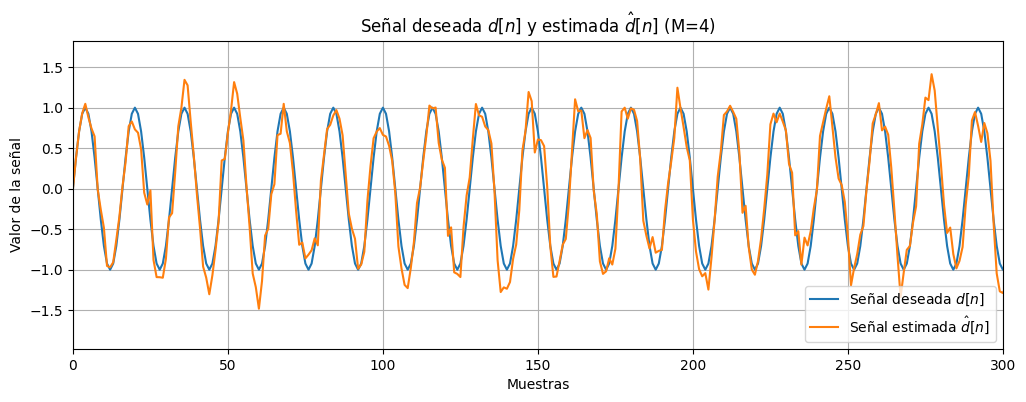

Error cuadrático medio para M=4: 0.04656751145291923


In [ ]:
# Definición del orden del filtro Wiener
M = 4

# Generamos la matriz de autocorrelaciones
R_v2 = np.zeros((M, M))
for i in range(M):
    for j in range(M):
        # Hallamos las autocorrelaciones, usamos la función np.mean para hallar
        # la esperanza. Entonces podemos calcular la autocorrelación como la formula
        R_v2[i, j] = np.mean(v2[np.abs(i - j):N] * v2[:N - np.abs(i - j)])

# Obtenemos el vector de correlación cruzada r_x_v2
r_x_v2 = np.zeros(M)
for k in range(M):
    # Hallamos la correlación cruzada
    r_x_v2[k] = np.mean(x[k:N - 1] * v2[0:N - (k + 1)])

# Cálculo de los coeficientes del filtro Wiener
W = np.dot(np.linalg.inv(R_v2), r_x_v2)
v1_estimado = signal.lfilter(W,[1],v2)

# Hallamos el error o d[n] estimado
error = x - v1_estimado
d_estimado = error

# Calculamos el error cuadrático medio
error_cuadratico = np.mean((dn[M:]-d_estimado[M:])**2)

# Visualización de los coeficientes del filtro Wiener
plt.figure(figsize=[12, 4])
plt.stem(W)
plt.title(f"Coeficientes del filtro Wiener (M={M})")
plt.xlabel('Índice del coeficiente')
plt.ylabel('Valor del coeficiente')
plt.grid('on')
plt.show()

# Visualización de la señal deseada y la estimada
plt.figure(figsize=[12, 4])
plt.plot(dn, label='Señal deseada $d[n]$')
plt.plot(d_estimado, label='Señal estimada $\hat{d}[n]$')
plt.title('Señal deseada $d[n]$ y estimada $\hat{d}[n]$ (M=4)')
plt.xlabel('Muestras')
plt.ylabel('Valor de la señal')
plt.xlim([0, 300])
plt.legend()
plt.grid('on')
plt.show()

# Impresión del error cuadrático medio
print(f'Error cuadrático medio para M={M}: {error_cuadratico}')
errores_cuadraticos.append(error_cuadratico)

### M = 8

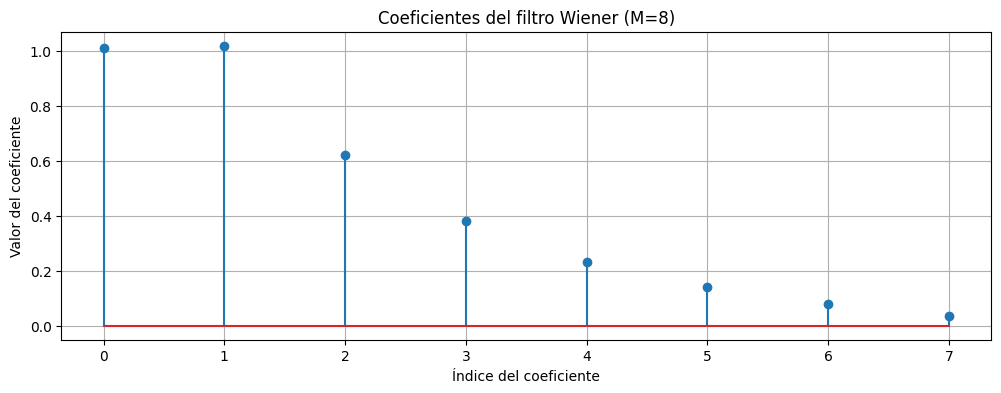

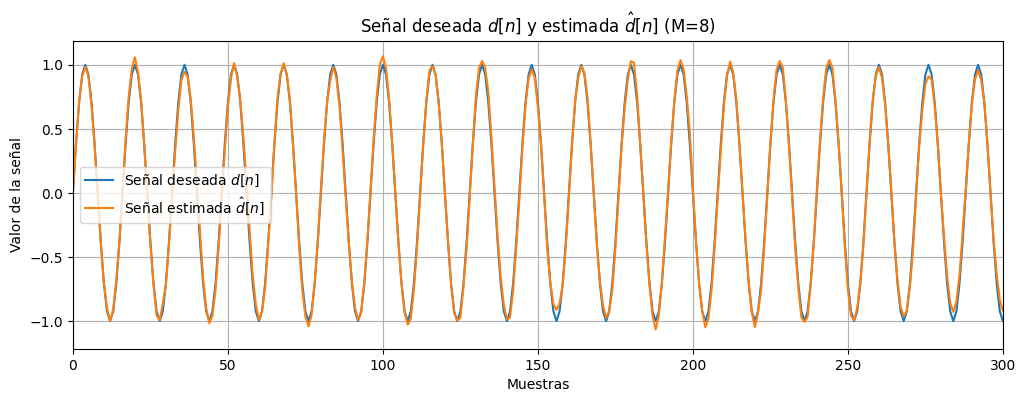

Error cuadrático medio para M=8: 0.0015922032587990258


In [ ]:
# Definición del orden del filtro Wiener
M = 8

# Generamos la matriz de autocorrelaciones
R_v2 = np.zeros((M, M))
for i in range(M):
    for j in range(M):
        # Hallamos las autocorrelaciones, usamos la función np.mean para hallar
        # la esperanza. Entonces podemos calcular la autocorrelación como la formula
        R_v2[i, j] = np.mean(v2[np.abs(i - j):N] * v2[:N - np.abs(i - j)])

# Obtenemos el vector de correlación cruzada r_x_v2
r_x_v2 = np.zeros(M)
for k in range(M):
    # Hallamos la correlación cruzada
    r_x_v2[k] = np.mean(x[k:N - 1] * v2[0:N - (k + 1)])

# Cálculo de los coeficientes del filtro Wiener
W = np.dot(np.linalg.inv(R_v2), r_x_v2)
v1_estimado = signal.lfilter(W,[1],v2)

# Hallamos el error o d[n] estimado
error = x - v1_estimado
d_estimado = error

# Calculamos el error cuadrático medio
error_cuadratico = np.mean((dn[M:]-d_estimado[M:])**2)

# Visualización de los coeficientes del filtro Wiener
plt.figure(figsize=[12, 4])
plt.stem(W)
plt.title(f"Coeficientes del filtro Wiener (M={M})")
plt.xlabel('Índice del coeficiente')
plt.ylabel('Valor del coeficiente')
plt.grid('on')
plt.show()

# Visualización de la señal deseada y la estimada
plt.figure(figsize=[12, 4])
plt.plot(dn, label='Señal deseada $d[n]$')
plt.plot(d_estimado, label='Señal estimada $\hat{d}[n]$')
plt.title('Señal deseada $d[n]$ y estimada $\hat{d}[n]$ (M=8)')
plt.xlabel('Muestras')
plt.ylabel('Valor de la señal')
plt.xlim([0, 300])
plt.legend()
plt.grid('on')
plt.show()

# Impresión del error cuadrático medio
print(f'Error cuadrático medio para M={M}: {error_cuadratico}')
errores_cuadraticos.append(error_cuadratico)

### M = 16

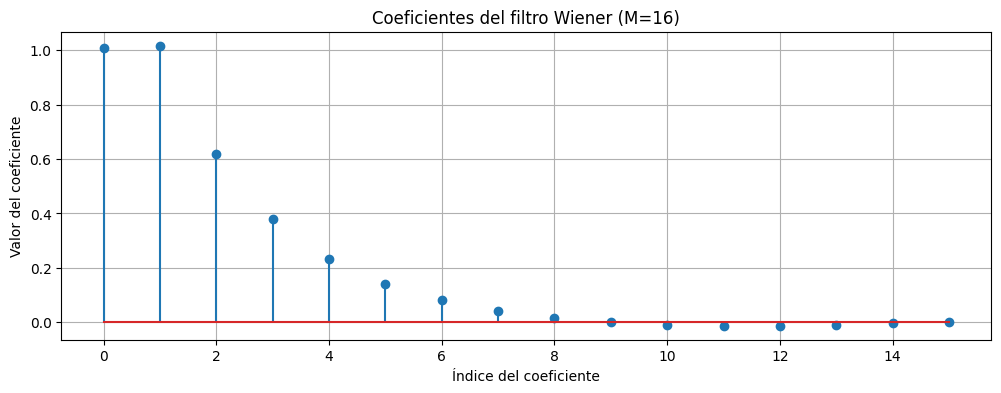

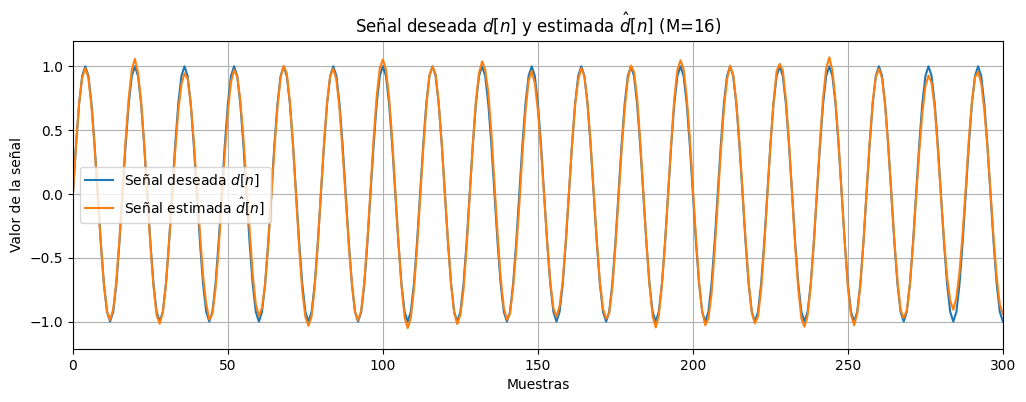

Error cuadrático medio para M=16: 0.001614979515164023


In [ ]:
# Definición del orden del filtro Wiener
M = 16

# Generamos la matriz de autocorrelaciones
R_v2 = np.zeros((M, M))
for i in range(M):
    for j in range(M):
        # Hallamos las autocorrelaciones, usamos la función np.mean para hallar
        # la esperanza. Entonces podemos calcular la autocorrelación como la formula
        R_v2[i, j] = np.mean(v2[np.abs(i - j):N] * v2[:N - np.abs(i - j)])

# Obtenemos el vector de correlación cruzada r_x_v2
r_x_v2 = np.zeros(M)
for k in range(M):
    # Hallamos la correlación cruzada
    r_x_v2[k] = np.mean(x[k:N - 1] * v2[0:N - (k + 1)])

# Cálculo de los coeficientes del filtro Wiener
W = np.dot(np.linalg.inv(R_v2), r_x_v2)
v1_estimado = signal.lfilter(W,[1],v2)

# Hallamos el error o d[n] estimado
error = x - v1_estimado
d_estimado = error

# Calculamos el error cuadrático medio
error_cuadratico = np.mean((dn[M:]-d_estimado[M:])**2)

# Visualización de los coeficientes del filtro Wiener
plt.figure(figsize=[12, 4])
plt.stem(W)
plt.title(f"Coeficientes del filtro Wiener (M={M})")
plt.xlabel('Índice del coeficiente')
plt.ylabel('Valor del coeficiente')
plt.grid('on')
plt.show()

# Visualización de la señal deseada y la estimada
plt.figure(figsize=[12, 4])
plt.plot(dn, label='Señal deseada $d[n]$')
plt.plot(d_estimado, label='Señal estimada $\hat{d}[n]$')
plt.title('Señal deseada $d[n]$ y estimada $\hat{d}[n]$ (M=16)')
plt.xlabel('Muestras')
plt.ylabel('Valor de la señal')
plt.xlim([0, 300])
plt.legend()
plt.grid('on')
plt.show()

# Impresión del error cuadrático medio
print(f'Error cuadrático medio para M={M}: {error_cuadratico}')
errores_cuadraticos.append(error_cuadratico)

### M = 32

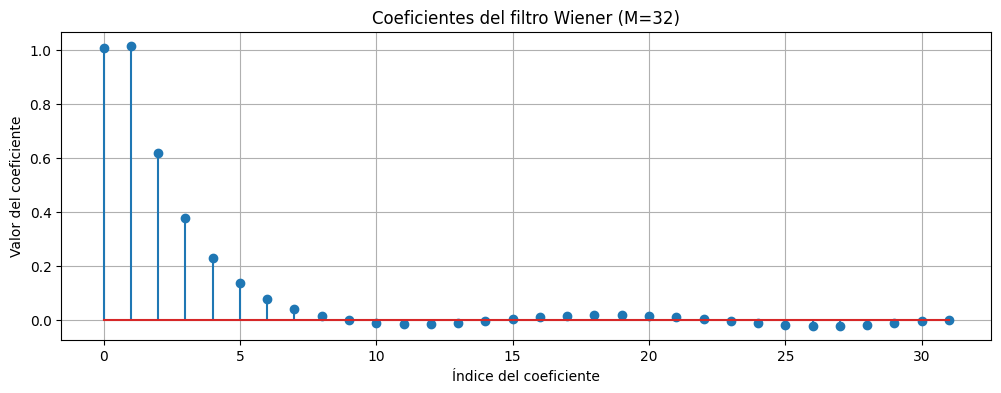

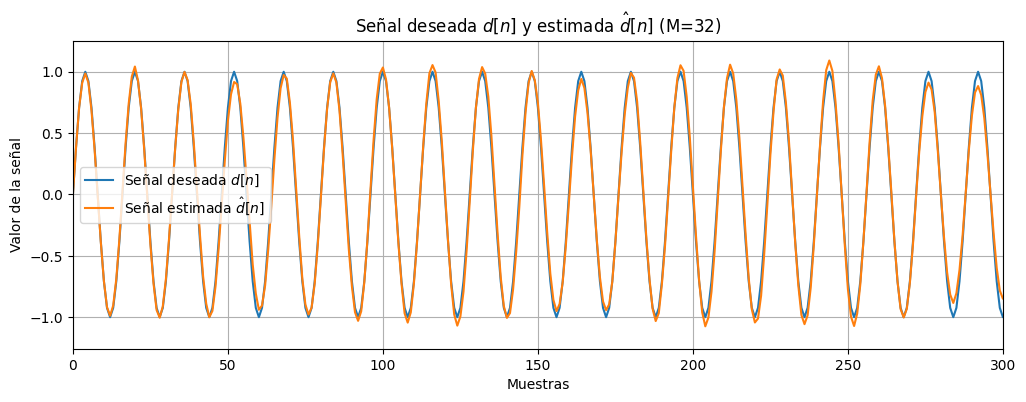

Error cuadrático medio para M=32: 0.0032456911743097916


In [ ]:
# Definición del orden del filtro Wiener
M = 32

# Generamos la matriz de autocorrelaciones
R_v2 = np.zeros((M, M))
for i in range(M):
    for j in range(M):
        # Hallamos las autocorrelaciones, usamos la función np.mean para hallar
        # la esperanza. Entonces podemos calcular la autocorrelación como la formula
        R_v2[i, j] = np.mean(v2[np.abs(i - j):N] * v2[:N - np.abs(i - j)])

# Obtenemos el vector de correlación cruzada r_x_v2
r_x_v2 = np.zeros(M)
for k in range(M):
    # Hallamos la correlación cruzada
    r_x_v2[k] = np.mean(x[k:N - 1] * v2[0:N - (k + 1)])

# Cálculo de los coeficientes del filtro Wiener
W = np.dot(np.linalg.inv(R_v2), r_x_v2)
v1_estimado = signal.lfilter(W,[1],v2)

# Hallamos el error o d[n] estimado
error = x - v1_estimado
d_estimado = error

# Calculamos el error cuadrático medio
error_cuadratico = np.mean((dn[M:]-d_estimado[M:])**2)

# Visualización de los coeficientes del filtro Wiener
plt.figure(figsize=[12, 4])
plt.stem(W)
plt.title(f"Coeficientes del filtro Wiener (M={M})")
plt.xlabel('Índice del coeficiente')
plt.ylabel('Valor del coeficiente')
plt.grid('on')
plt.show()

# Visualización de la señal deseada y la estimada
plt.figure(figsize=[12, 4])
plt.plot(dn, label='Señal deseada $d[n]$')
plt.plot(d_estimado, label='Señal estimada $\hat{d}[n]$')
plt.title('Señal deseada $d[n]$ y estimada $\hat{d}[n]$ (M=32)')
plt.xlabel('Muestras')
plt.ylabel('Valor de la señal')
plt.xlim([0, 300])
plt.legend()
plt.grid('on')
plt.show()

# Impresión del error cuadrático medio
print(f'Error cuadrático medio para M={M}: {error_cuadratico}')
errores_cuadraticos.append(error_cuadratico)

### M = 64

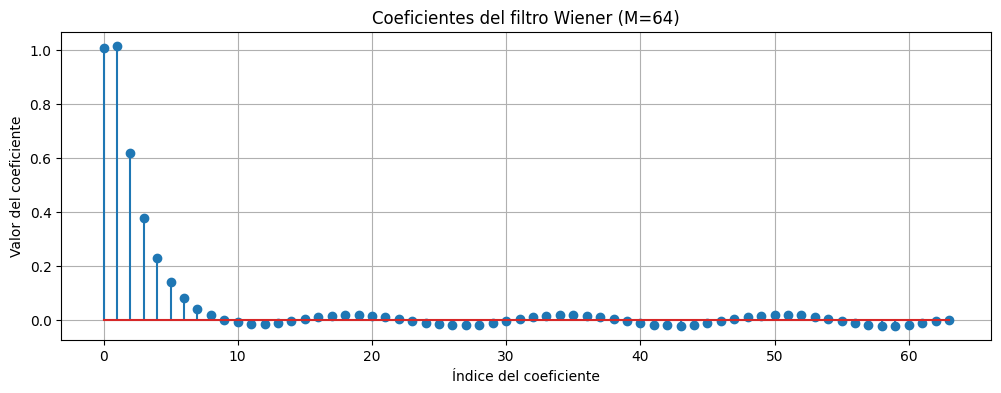

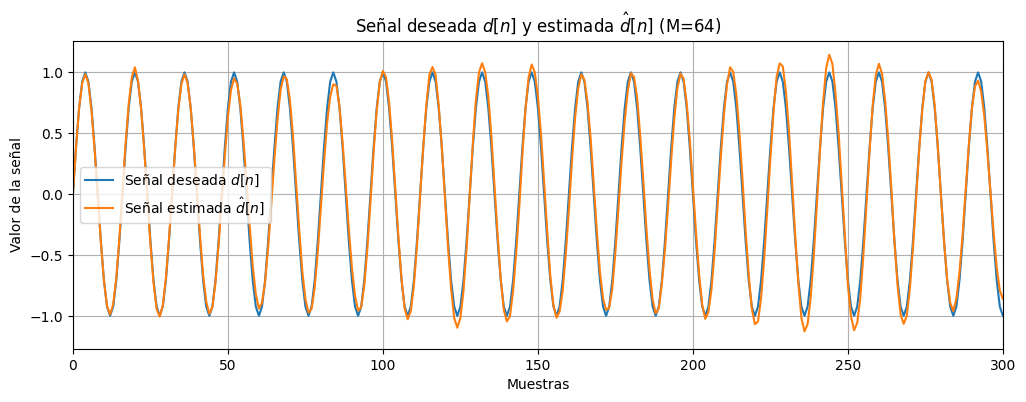

Error cuadrático medio para M=64: 0.006760638595734597


In [ ]:
# Definición del orden del filtro Wiener
M = 64

# Generamos la matriz de autocorrelaciones
R_v2 = np.zeros((M, M))
for i in range(M):
    for j in range(M):
        # Hallamos las autocorrelaciones, usamos la función np.mean para hallar
        # la esperanza. Entonces podemos calcular la autocorrelación como la formula
        R_v2[i, j] = np.mean(v2[np.abs(i - j):N] * v2[:N - np.abs(i - j)])

# Obtenemos el vector de correlación cruzada r_x_v2
r_x_v2 = np.zeros(M)
for k in range(M):
    # Hallamos la correlación cruzada
    r_x_v2[k] = np.mean(x[k:N - 1] * v2[0:N - (k + 1)])

# Cálculo de los coeficientes del filtro Wiener
W = np.dot(np.linalg.inv(R_v2), r_x_v2)
v1_estimado = signal.lfilter(W,[1],v2)

# Hallamos el error o d[n] estimado
error = x - v1_estimado
d_estimado = error

# Calculamos el error cuadrático medio
error_cuadratico = np.mean((dn[M:]-d_estimado[M:])**2)

# Visualización de los coeficientes del filtro Wiener
plt.figure(figsize=[12, 4])
plt.stem(W)
plt.title(f"Coeficientes del filtro Wiener (M={M})")
plt.xlabel('Índice del coeficiente')
plt.ylabel('Valor del coeficiente')
plt.grid('on')
plt.show()

# Visualización de la señal deseada y la estimada
plt.figure(figsize=[12, 4])
plt.plot(dn, label='Señal deseada $d[n]$')
plt.plot(d_estimado, label='Señal estimada $\hat{d}[n]$')
plt.title('Señal deseada $d[n]$ y estimada $\hat{d}[n]$ (M=64)')
plt.xlabel('Muestras')
plt.ylabel('Valor de la señal')
plt.xlim([0, 300])
plt.legend()
plt.grid('on')
plt.show()

# Impresión del error cuadrático medio
print(f'Error cuadrático medio para M={M}: {error_cuadratico}')
errores_cuadraticos.append(error_cuadratico)

### M = 128

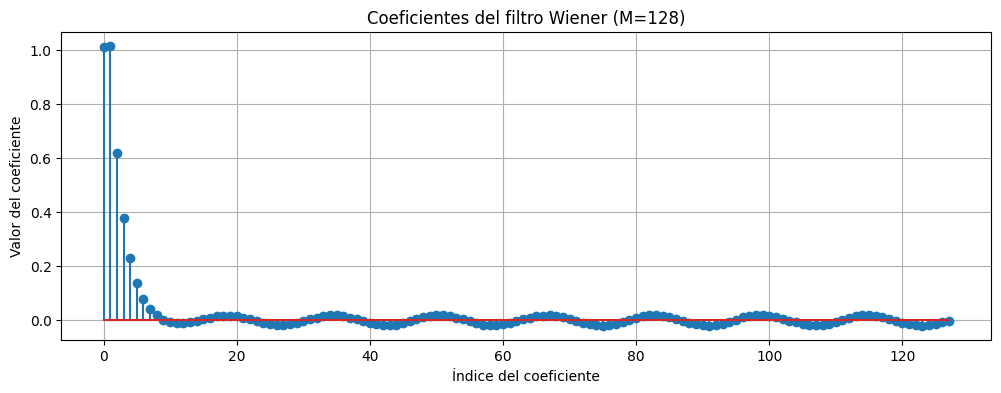

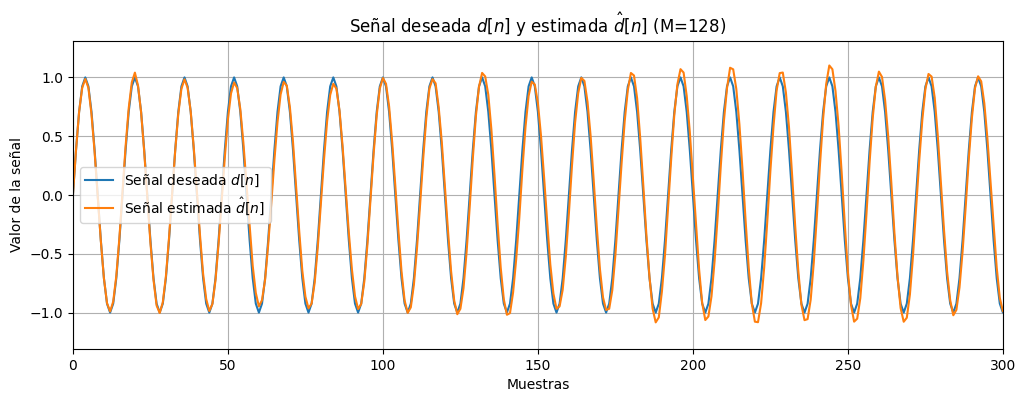

Error cuadrático medio para M=128: 0.01294854039540496


In [ ]:
# Definición del orden del filtro Wiener
M = 128

# Generamos la matriz de autocorrelaciones
R_v2 = np.zeros((M, M))
for i in range(M):
    for j in range(M):
        # Hallamos las autocorrelaciones, usamos la función np.mean para hallar
        # la esperanza. Entonces podemos calcular la autocorrelación como la formula
        R_v2[i, j] = np.mean(v2[np.abs(i - j):N] * v2[:N - np.abs(i - j)])

# Obtenemos el vector de correlación cruzada r_x_v2
r_x_v2 = np.zeros(M)
for k in range(M):
    # Hallamos la correlación cruzada
    r_x_v2[k] = np.mean(x[k:N - 1] * v2[0:N - (k + 1)])

# Cálculo de los coeficientes del filtro Wiener
W = np.dot(np.linalg.inv(R_v2), r_x_v2)
v1_estimado = signal.lfilter(W,[1],v2)

# Hallamos el error o d[n] estimado
error = x - v1_estimado
d_estimado = error

# Calculamos el error cuadrático medio
error_cuadratico = np.mean((dn[M:]-d_estimado[M:])**2)

# Visualización de los coeficientes del filtro Wiener
plt.figure(figsize=[12, 4])
plt.stem(W)
plt.title(f"Coeficientes del filtro Wiener (M={M})")
plt.xlabel('Índice del coeficiente')
plt.ylabel('Valor del coeficiente')
plt.grid('on')
plt.show()

# Visualización de la señal deseada y la estimada
plt.figure(figsize=[12, 4])
plt.plot(dn, label='Señal deseada $d[n]$')
plt.plot(d_estimado, label='Señal estimada $\hat{d}[n]$')
plt.title('Señal deseada $d[n]$ y estimada $\hat{d}[n]$ (M=128)')
plt.xlabel('Muestras')
plt.ylabel('Valor de la señal')
plt.xlim([0, 300])
plt.legend()
plt.grid('on')
plt.show()

# Impresión del error cuadrático medio
print(f'Error cuadrático medio para M={M}: {error_cuadratico}')
errores_cuadraticos.append(error_cuadratico)

In [ ]:
print(errores_cuadraticos)

[0.3549451107421771, 0.04656751145291923, 0.0015922032587990258, 0.001614979515164023, 0.0032456911743097916, 0.006760638595734597, 0.01294854039540496]


| M    |     Error Cuadrático Medio        |
|------|-----------------------------------|
| 2    | 0.3549451107421771                |
| 4    | 0.04656751145291923               |
| 8    | 0.0015922032587990258             |
| 16   | 0.001614979515164023              |
| 32   | 0.0032456911743097916             |
| 64   | 0.006760638595734597              |
| 128  | 0.01294854039540496               |

> 1. ¿En qué caso se obtiene el menor error cuadrático?
> 
> Se puede observar claramente que el menor error cuadrático medio ocurre cuando el valor de M es 16, esta valor indica la posibilidad de estimar precisamente la señal d[n] cuando la longitud es de 16 coeficientes. 
>
> 2. ¿Cómo varían los coeficientes del filtro Wiener conforme aumenta M?
> 
> Sobre la variación del error cuadrático medio conforme se incrementa M, observamos que mientras más se incrementan el número de coeficientes mejor se adapta el filtro a la señal de entrada y permite eliminar más efectivamente el ruido, el error cuadrático tenderá a reeducirse conforme incrementemos el número de coeficientes del cancelador de ruido pero llegará a un mínimo y luego volverá a incrementarse para valores a partir de los 32 coeficientes, esto significa que el cancelador esta capturando la señal y el ruido con sobre ajustes, esto provoca que los coeficientes se vuelvan excesivamente pequeños.
>
> 3. ¿Por qué incrementa ligeramente el error para valores muy largos de M, como se relaciona este comportamiento con los coeficientes del filtro?
>
>  La razón de porque se incrementa el error cuadrático medio ligeramente cuando se pasa del M óptimo recae en que el filtro Wiener empieza a sobre ajustarse al ruido, con sobre ajustarse al ruido nos referimos a que el filtro prioriza la predicción de valores del ruido por sobre detectar la señal deseada lo que provoca al final un aumento ligero del error cuadrático medio.
>
> Este comportamiento se relaciona com M dado que de M depende si el filtro se sobre ajusta, está mal adaptado o se encuentra en un estado óptimo, cuando se coloca un valor por encima del óptimo los coeficientes del filtro oscilan y se distorsionan atenuandose más y más conforme incrementa n, Las oscilaciones y atenuaciones que se presentan en los coeficientes que aparecen cuando se sobrepasa el M óptimo reflejan una sobre adaptación del cancelador de ruido a las variaciones de la señal de entrada incluyendo el ruido.

2. Ahora vamos a analizar la performance del algoritmo LMS para el mismo problema. En este caso vamos a considerar que M = 16. De forma similar al caso anterior, prepare una tabla del error medio cuadrático para diferentes valores del paso µ  desde 0,001 hasta 0,008. Presente gráficos de como varían los coeficientes del filtro LMS en cada caso. ¿En qué caso se produce el menor error cuadrático? ¿En que casó los coeficientes del algoritmo LMS convergen más rápido? ¿Cómo se relaciona la convergencia con la precisión en la estimación de los coeficientes del algoritmos LMS? Justifique sus respuestas

In [ ]:
errores_cuadraticos = []

> Para esta parte se implementa el algoritmo LMS de 16 coeficientes.

In [ ]:
# Definimos el orden del filtro Wiener
M = 16

# Construimos la matriz de autocorrelación R_v2
R_v2 = np.zeros((M, M))
for i in range(M):
    for j in range(M):
        # Calculamos las autocorrelaciones utilizando la media
        R_v2[i, j] = np.mean(v2[np.abs(i - j):N] * v2[:N - np.abs(i - j)])

# Calculamos el vector de correlación cruzada entre x y v2
r_x_v2 = np.zeros(M)
for k in range(M):
    # Estimamos la correlación cruzada
    r_x_v2[k] = np.mean(x[k:N - 1] * v2[0:N - (k + 1)])

# Estimamos los coeficientes del filtro Wiener usando la inversa de R_v2
W = np.dot(np.linalg.inv(R_v2), r_x_v2)
v1_estimado = signal.lfilter(W, [1], v2)

# Calculamos el error estimado d[n]
err = x - v1_estimado
d_estimado = err

# Calculamos el error cuadrático medio
error_cuadratico_medio = np.mean((dn[M:] - d_estimado[M:]) ** 2)

### $\mu$ = 0.001

Error cuadrático medio para u=0.001:  0.004451440463751494


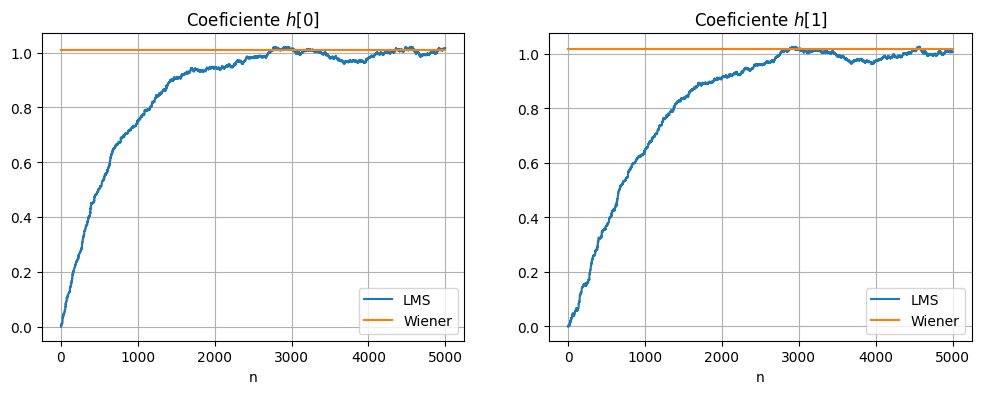

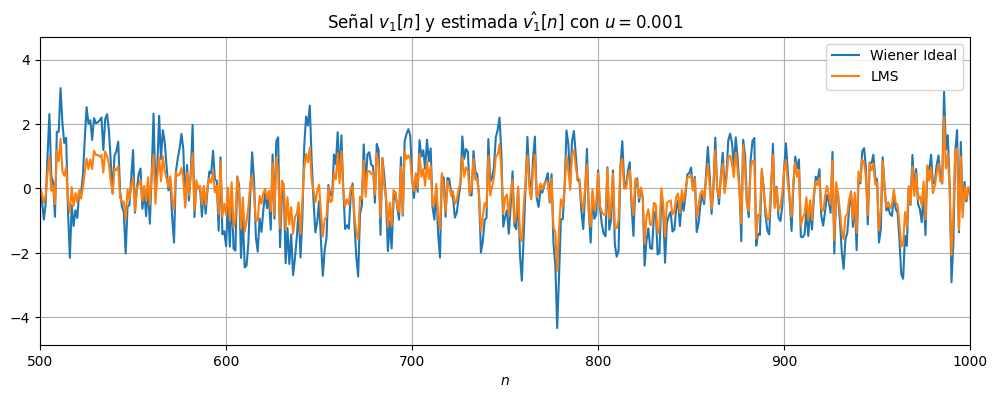

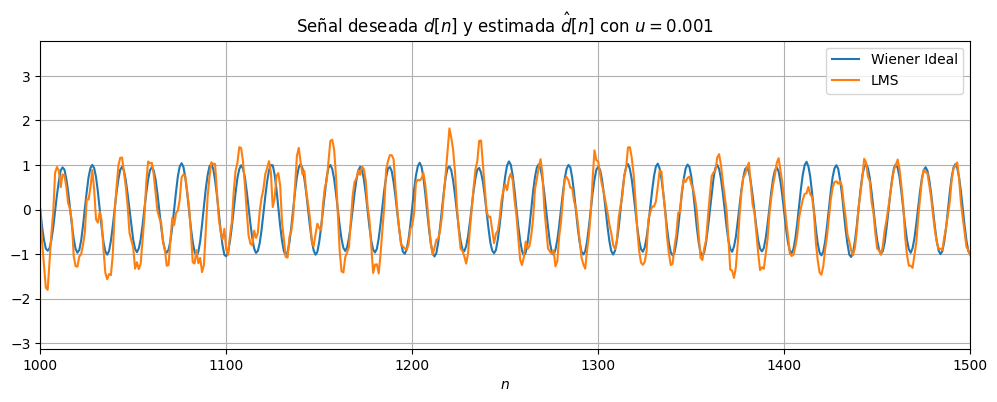

In [ ]:
h_LMS = np.zeros((M,N))
# v2[n] ingresa al filtro
vn2_LMS = np.zeros(N)

mu = 0.001
xx = np.zeros(M)
for n in range(N-1):
    xx = np.roll(xx,1)
    xx[0] = v2[n]
    vn2_LMS[n] = np.dot(h_LMS[:,n],xx)
    en = x[n] - vn2_LMS[n]
    h_LMS[:,n+1] = h_LMS[:,n] + 2 * mu * en * xx

# Hallamos el error o d[n] estimado
err_LMS = x - vn2_LMS

error_cuadratico_LMS = np.mean((err[N//2:] - err_LMS[N//2:]) ** 2)
print(f'Error cuadrático medio para u=0.001: ',error_cuadratico_LMS)
errores_cuadraticos.append(error_cuadratico_LMS)

# Graficamos h[0]
plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plt.plot(h_LMS[0,:])
plt.plot([0,N],[W[0],W[0]])
plt.grid('on')
plt.xlabel('n')
plt.title('Coeficiente $h[0]$')
plt.legend(['LMS','Wiener'])

# Graficamos h[1]
plt.subplot(1,2,2)
plt.plot(h_LMS[1,:])
plt.plot([0,N],[W[1],W[1]])
plt.grid('on')
plt.xlabel('n')
plt.title('Coeficiente $h[1]$')
plt.legend(['LMS','Wiener'])

# Comparando Wiener ideal vs. LMS con v1[n]
plt.figure(figsize=[12,4])
plt.plot(v1_estimado)
plt.plot(vn2_LMS)
plt.grid('on')
plt.xlabel('$n$')
plt.xlim([500,1000])
plt.title('Señal $v_1[n]$ y estimada $\hat{v_1}[n]$ con $u=0.001$')
plt.legend(['Wiener Ideal','LMS'])

# Comparando Wiener ideal vs. LMS en d[n]
plt.figure(figsize=[12, 4])
plt.plot(err)
plt.plot(err_LMS)
plt.legend(['Wiener Ideal','LMS'])
plt.xlabel('$n$')
plt.xlim([1000, 1500])
plt.title('Señal deseada $d[n]$ y estimada $\hat{d}[n]$ con $u=0.001$')
plt.grid('on')


### $\mu$ = 0.002

Error cuadrático medio para u=0.001:  0.011180225484957377


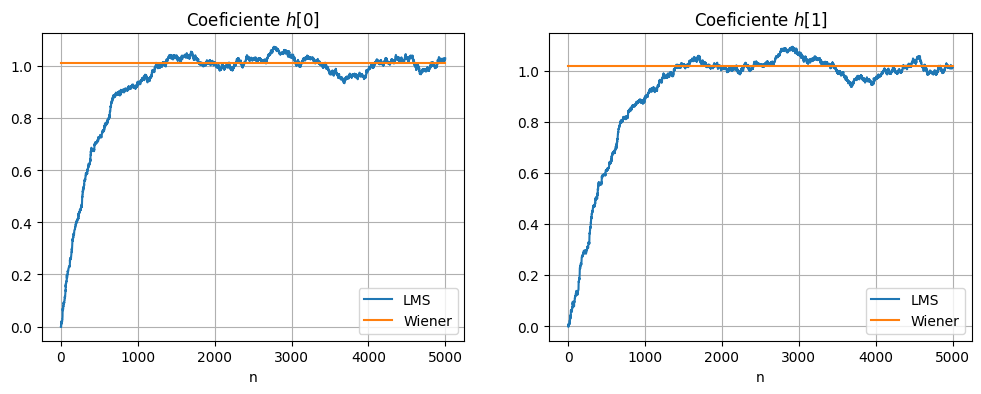

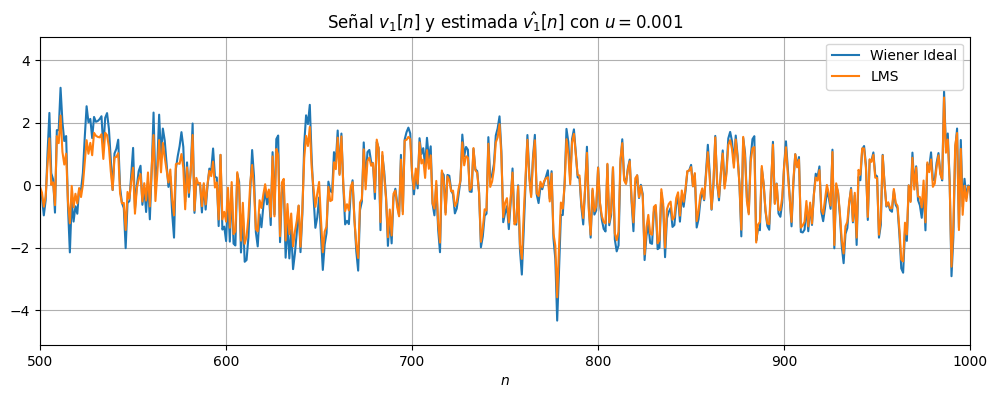

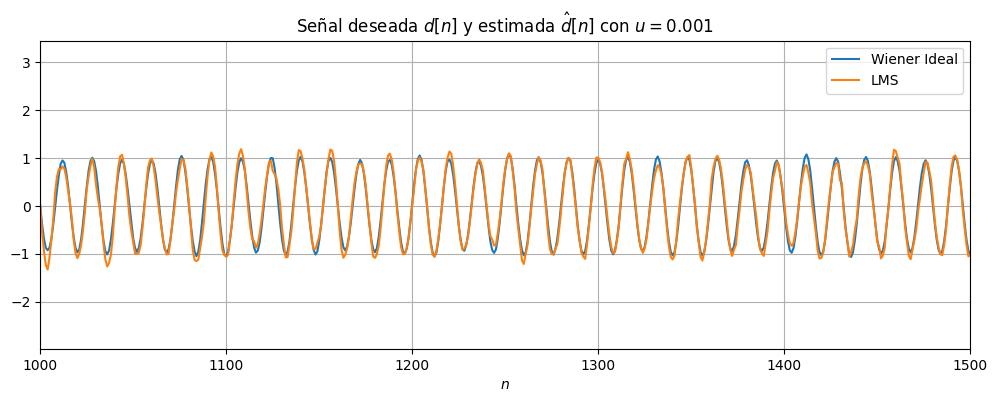

In [ ]:
h_LMS = np.zeros((M,N))
# v2[n] ingresa al filtro
vn2_LMS = np.zeros(N)

mu = 0.002
xx = np.zeros(M)
for n in range(N-1):
    xx = np.roll(xx,1)
    xx[0] = v2[n]
    vn2_LMS[n] = np.dot(h_LMS[:,n],xx)
    en = x[n] - vn2_LMS[n]
    h_LMS[:,n+1] = h_LMS[:,n] + 2 * mu * en * xx

# Hallamos el error o d[n] estimado
err_LMS = x - vn2_LMS

error_cuadratico_LMS = np.mean((err[N//2:] - err_LMS[N//2:]) ** 2)
print(f'Error cuadrático medio para u=0.001: ',error_cuadratico_LMS)
errores_cuadraticos.append(error_cuadratico_LMS)

# Graficamos h[0]
plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plt.plot(h_LMS[0,:])
plt.plot([0,N],[W[0],W[0]])
plt.grid('on')
plt.xlabel('n')
plt.title('Coeficiente $h[0]$')
plt.legend(['LMS','Wiener'])

# Graficamos h[1]
plt.subplot(1,2,2)
plt.plot(h_LMS[1,:])
plt.plot([0,N],[W[1],W[1]])
plt.grid('on')
plt.xlabel('n')
plt.title('Coeficiente $h[1]$')
plt.legend(['LMS','Wiener'])

# Comparando Wiener ideal vs. LMS con v1[n]
plt.figure(figsize=[12,4])
plt.plot(v1_estimado)
plt.plot(vn2_LMS)
plt.grid('on')
plt.xlabel('$n$')
plt.xlim([500,1000])
plt.title('Señal $v_1[n]$ y estimada $\hat{v_1}[n]$ con $u=0.001$')
plt.legend(['Wiener Ideal','LMS'])

# Comparando Wiener ideal vs. LMS en d[n]
plt.figure(figsize=[12, 4])
plt.plot(err)
plt.plot(err_LMS)
plt.legend(['Wiener Ideal','LMS'])
plt.xlabel('$n$')
plt.xlim([1000, 1500])
plt.title('Señal deseada $d[n]$ y estimada $\hat{d}[n]$ con $u=0.001$')
plt.grid('on')

### $\mu$ = 0.003

Error cuadrático medio para u=0.001:  0.01949247365487197


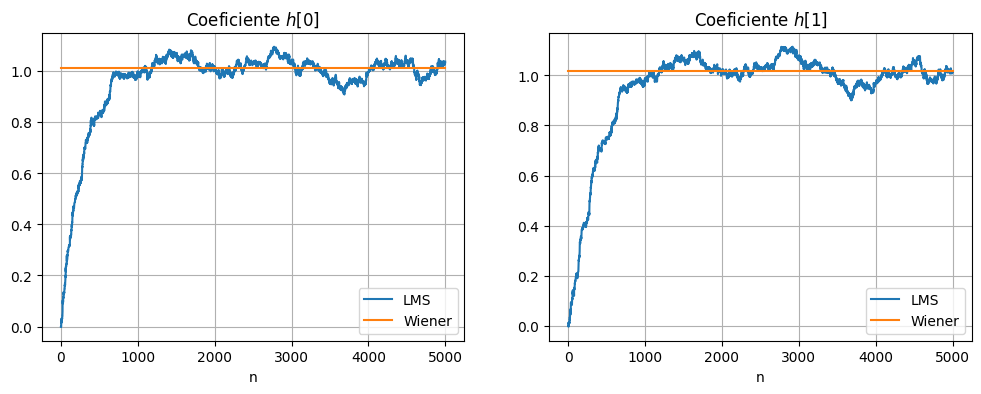

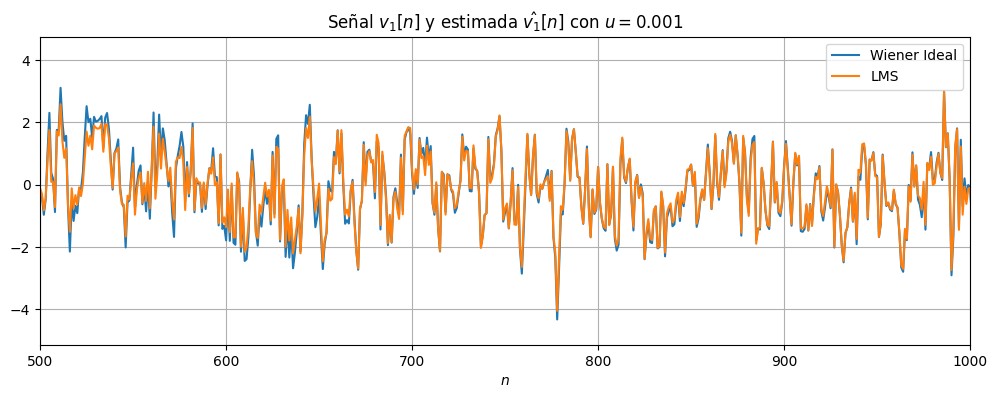

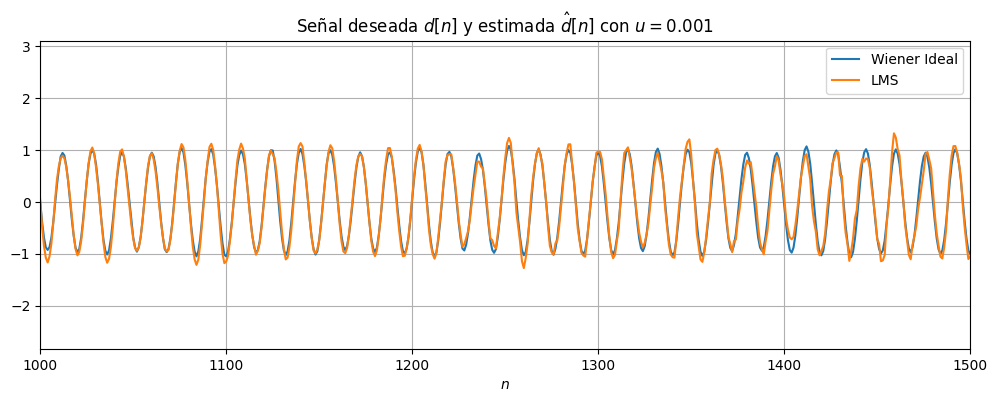

In [ ]:
h_LMS = np.zeros((M,N))
# v2[n] ingresa al filtro
vn2_LMS = np.zeros(N)

mu = 0.003
xx = np.zeros(M)
for n in range(N-1):
    xx = np.roll(xx,1)
    xx[0] = v2[n]
    vn2_LMS[n] = np.dot(h_LMS[:,n],xx)
    en = x[n] - vn2_LMS[n]
    h_LMS[:,n+1] = h_LMS[:,n] + 2 * mu * en * xx

# Hallamos el error o d[n] estimado
err_LMS = x - vn2_LMS

error_cuadratico_LMS = np.mean((err[N//2:] - err_LMS[N//2:]) ** 2)
print(f'Error cuadrático medio para u=0.001: ',error_cuadratico_LMS)
errores_cuadraticos.append(error_cuadratico_LMS)

# Graficamos h[0]
plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plt.plot(h_LMS[0,:])
plt.plot([0,N],[W[0],W[0]])
plt.grid('on')
plt.xlabel('n')
plt.title('Coeficiente $h[0]$')
plt.legend(['LMS','Wiener'])

# Graficamos h[1]
plt.subplot(1,2,2)
plt.plot(h_LMS[1,:])
plt.plot([0,N],[W[1],W[1]])
plt.grid('on')
plt.xlabel('n')
plt.title('Coeficiente $h[1]$')
plt.legend(['LMS','Wiener'])

# Comparando Wiener ideal vs. LMS con v1[n]
plt.figure(figsize=[12,4])
plt.plot(v1_estimado)
plt.plot(vn2_LMS)
plt.grid('on')
plt.xlabel('$n$')
plt.xlim([500,1000])
plt.title('Señal $v_1[n]$ y estimada $\hat{v_1}[n]$ con $u=0.001$')
plt.legend(['Wiener Ideal','LMS'])

# Comparando Wiener ideal vs. LMS en d[n]
plt.figure(figsize=[12, 4])
plt.plot(err)
plt.plot(err_LMS)
plt.legend(['Wiener Ideal','LMS'])
plt.xlabel('$n$')
plt.xlim([1000, 1500])
plt.title('Señal deseada $d[n]$ y estimada $\hat{d}[n]$ con $u=0.001$')
plt.grid('on')

### $\mu$ = 0.004

Error cuadrático medio para u=0.001:  0.028377842556789545


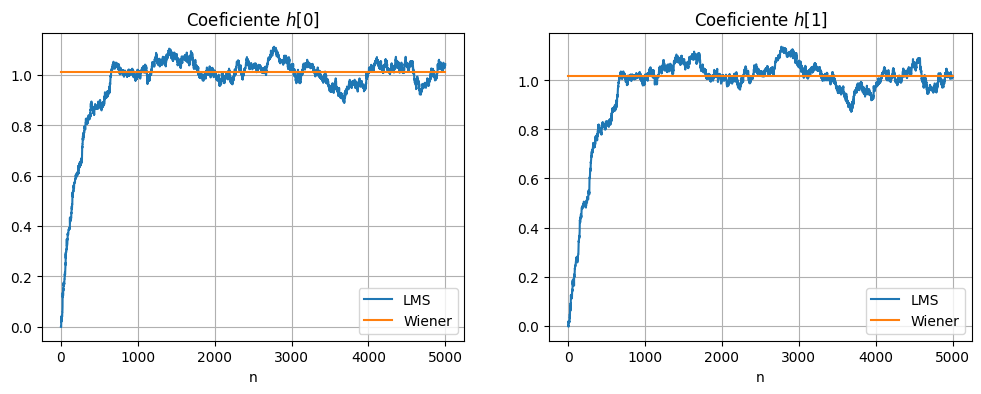

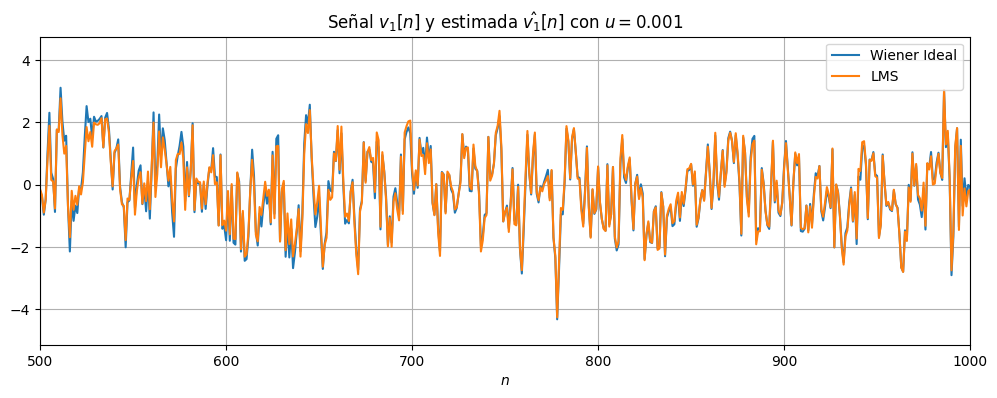

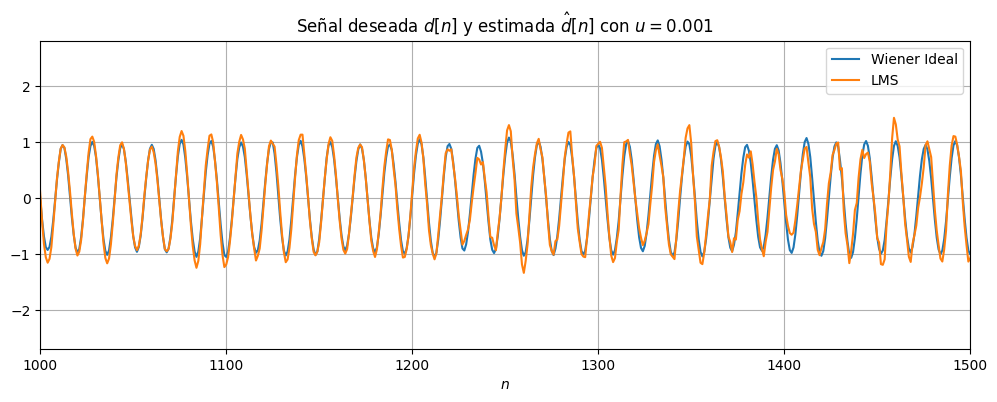

In [ ]:
h_LMS = np.zeros((M,N))
# v2[n] ingresa al filtro
vn2_LMS = np.zeros(N)

mu = 0.004
xx = np.zeros(M)
for n in range(N-1):
    xx = np.roll(xx,1)
    xx[0] = v2[n]
    vn2_LMS[n] = np.dot(h_LMS[:,n],xx)
    en = x[n] - vn2_LMS[n]
    h_LMS[:,n+1] = h_LMS[:,n] + 2 * mu * en * xx

# Hallamos el error o d[n] estimado
err_LMS = x - vn2_LMS

error_cuadratico_LMS = np.mean((err[N//2:] - err_LMS[N//2:]) ** 2)
print(f'Error cuadrático medio para u=0.001: ',error_cuadratico_LMS)
errores_cuadraticos.append(error_cuadratico_LMS)

# Graficamos h[0]
plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plt.plot(h_LMS[0,:])
plt.plot([0,N],[W[0],W[0]])
plt.grid('on')
plt.xlabel('n')
plt.title('Coeficiente $h[0]$')
plt.legend(['LMS','Wiener'])

# Graficamos h[1]
plt.subplot(1,2,2)
plt.plot(h_LMS[1,:])
plt.plot([0,N],[W[1],W[1]])
plt.grid('on')
plt.xlabel('n')
plt.title('Coeficiente $h[1]$')
plt.legend(['LMS','Wiener'])

# Comparando Wiener ideal vs. LMS con v1[n]
plt.figure(figsize=[12,4])
plt.plot(v1_estimado)
plt.plot(vn2_LMS)
plt.grid('on')
plt.xlabel('$n$')
plt.xlim([500,1000])
plt.title('Señal $v_1[n]$ y estimada $\hat{v_1}[n]$ con $u=0.001$')
plt.legend(['Wiener Ideal','LMS'])

# Comparando Wiener ideal vs. LMS en d[n]
plt.figure(figsize=[12, 4])
plt.plot(err)
plt.plot(err_LMS)
plt.legend(['Wiener Ideal','LMS'])
plt.xlabel('$n$')
plt.xlim([1000, 1500])
plt.title('Señal deseada $d[n]$ y estimada $\hat{d}[n]$ con $u=0.001$')
plt.grid('on')

### $\mu$ = 0.005

Error cuadrático medio para u=0.001:  0.037783062116173445


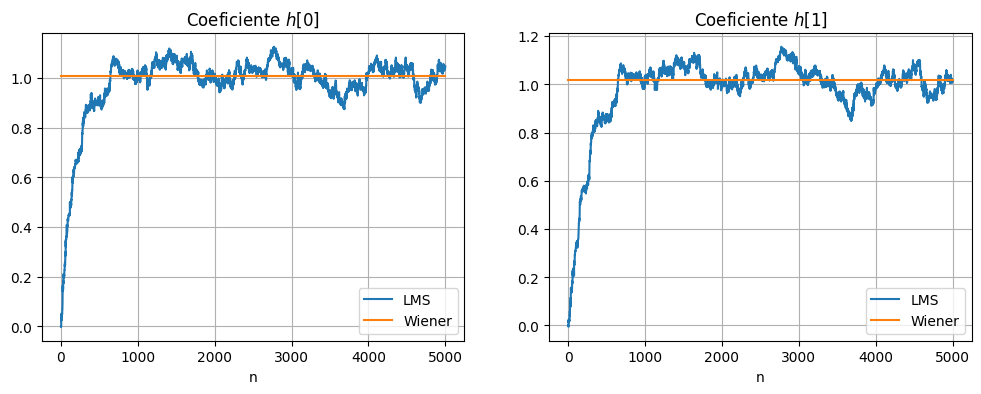

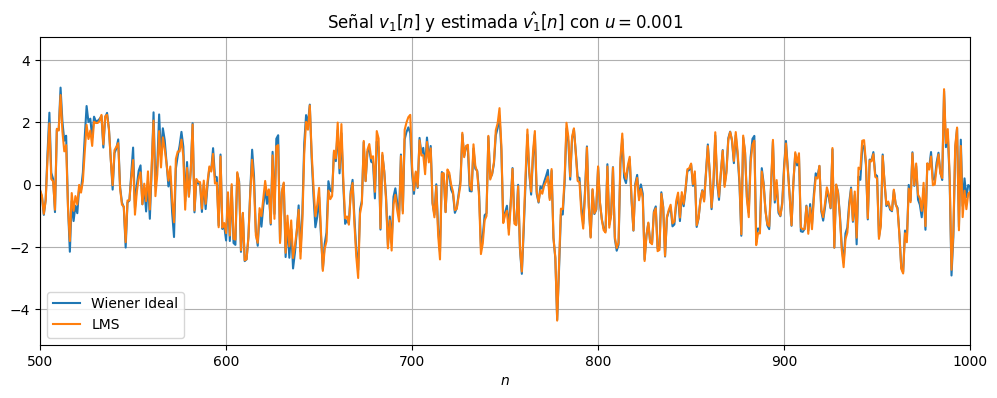

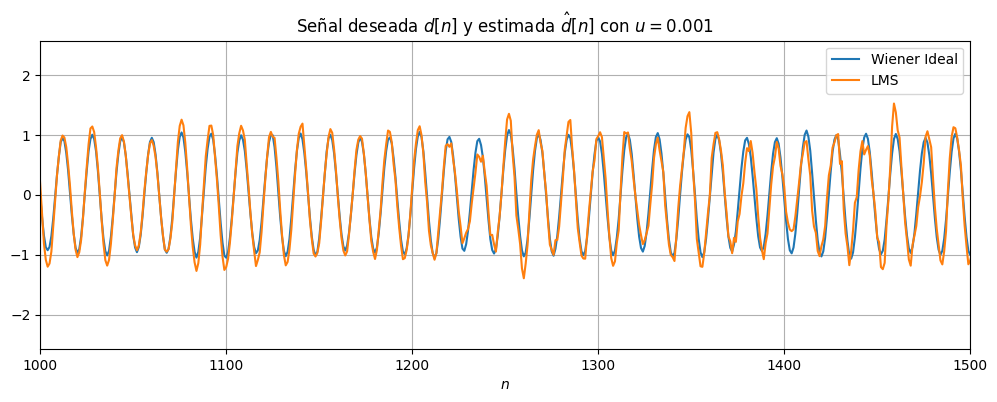

In [ ]:
h_LMS = np.zeros((M,N))
# v2[n] ingresa al filtro
vn2_LMS = np.zeros(N)

mu = 0.005
xx = np.zeros(M)
for n in range(N-1):
    xx = np.roll(xx,1)
    xx[0] = v2[n]
    vn2_LMS[n] = np.dot(h_LMS[:,n],xx)
    en = x[n] - vn2_LMS[n]
    h_LMS[:,n+1] = h_LMS[:,n] + 2 * mu * en * xx

# Hallamos el error o d[n] estimado
err_LMS = x - vn2_LMS

error_cuadratico_LMS = np.mean((err[N//2:] - err_LMS[N//2:]) ** 2)
print(f'Error cuadrático medio para u=0.001: ',error_cuadratico_LMS)
errores_cuadraticos.append(error_cuadratico_LMS)

# Graficamos h[0]
plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plt.plot(h_LMS[0,:])
plt.plot([0,N],[W[0],W[0]])
plt.grid('on')
plt.xlabel('n')
plt.title('Coeficiente $h[0]$')
plt.legend(['LMS','Wiener'])

# Graficamos h[1]
plt.subplot(1,2,2)
plt.plot(h_LMS[1,:])
plt.plot([0,N],[W[1],W[1]])
plt.grid('on')
plt.xlabel('n')
plt.title('Coeficiente $h[1]$')
plt.legend(['LMS','Wiener'])

# Comparando Wiener ideal vs. LMS con v1[n]
plt.figure(figsize=[12,4])
plt.plot(v1_estimado)
plt.plot(vn2_LMS)
plt.grid('on')
plt.xlabel('$n$')
plt.xlim([500,1000])
plt.title('Señal $v_1[n]$ y estimada $\hat{v_1}[n]$ con $u=0.001$')
plt.legend(['Wiener Ideal','LMS'])

# Comparando Wiener ideal vs. LMS en d[n]
plt.figure(figsize=[12, 4])
plt.plot(err)
plt.plot(err_LMS)
plt.legend(['Wiener Ideal','LMS'])
plt.xlabel('$n$')
plt.xlim([1000, 1500])
plt.title('Señal deseada $d[n]$ y estimada $\hat{d}[n]$ con $u=0.001$')
plt.grid('on')

### $\mu$ = 0.006

Error cuadrático medio para u=0.001:  0.04780014909716713


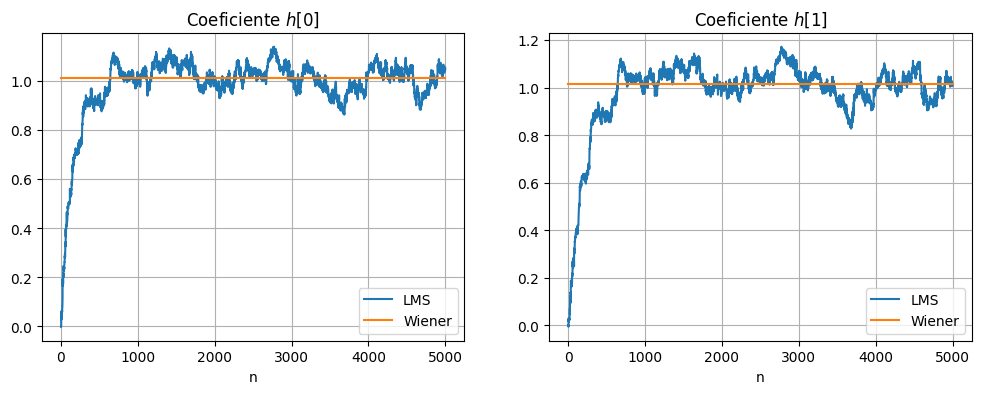

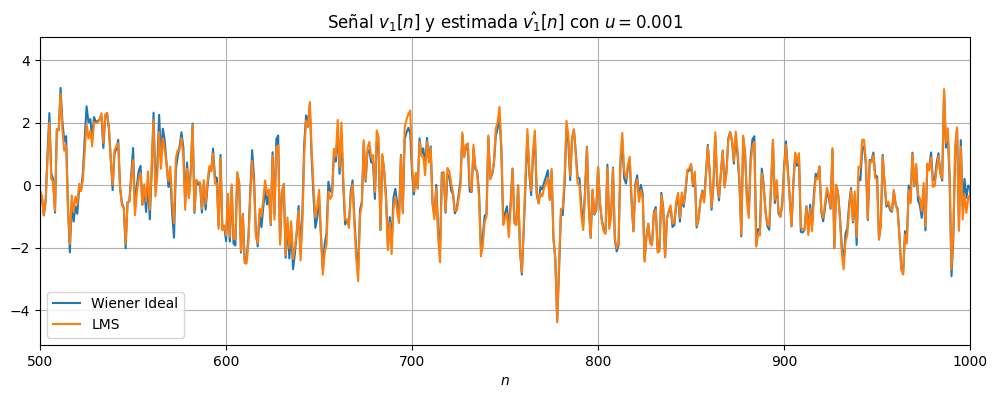

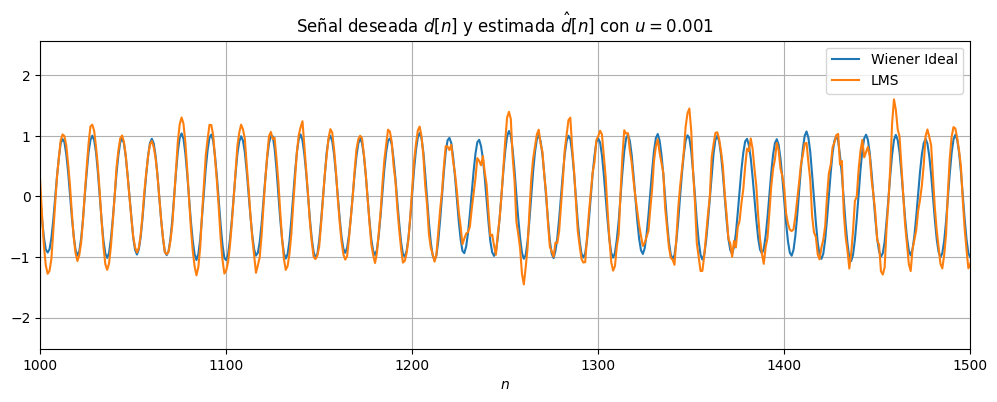

In [ ]:
h_LMS = np.zeros((M,N))
# v2[n] ingresa al filtro
vn2_LMS = np.zeros(N)

mu = 0.006
xx = np.zeros(M)
for n in range(N-1):
    xx = np.roll(xx,1)
    xx[0] = v2[n]
    vn2_LMS[n] = np.dot(h_LMS[:,n],xx)
    en = x[n] - vn2_LMS[n]
    h_LMS[:,n+1] = h_LMS[:,n] + 2 * mu * en * xx

# Hallamos el error o d[n] estimado
err_LMS = x - vn2_LMS

error_cuadratico_LMS = np.mean((err[N//2:] - err_LMS[N//2:]) ** 2)
print(f'Error cuadrático medio para u=0.001: ',error_cuadratico_LMS)
errores_cuadraticos.append(error_cuadratico_LMS)

# Graficamos h[0]
plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plt.plot(h_LMS[0,:])
plt.plot([0,N],[W[0],W[0]])
plt.grid('on')
plt.xlabel('n')
plt.title('Coeficiente $h[0]$')
plt.legend(['LMS','Wiener'])

# Graficamos h[1]
plt.subplot(1,2,2)
plt.plot(h_LMS[1,:])
plt.plot([0,N],[W[1],W[1]])
plt.grid('on')
plt.xlabel('n')
plt.title('Coeficiente $h[1]$')
plt.legend(['LMS','Wiener'])

# Comparando Wiener ideal vs. LMS con v1[n]
plt.figure(figsize=[12,4])
plt.plot(v1_estimado)
plt.plot(vn2_LMS)
plt.grid('on')
plt.xlabel('$n$')
plt.xlim([500,1000])
plt.title('Señal $v_1[n]$ y estimada $\hat{v_1}[n]$ con $u=0.001$')
plt.legend(['Wiener Ideal','LMS'])

# Comparando Wiener ideal vs. LMS en d[n]
plt.figure(figsize=[12, 4])
plt.plot(err)
plt.plot(err_LMS)
plt.legend(['Wiener Ideal','LMS'])
plt.xlabel('$n$')
plt.xlim([1000, 1500])
plt.title('Señal deseada $d[n]$ y estimada $\hat{d}[n]$ con $u=0.001$')
plt.grid('on')

### $\mu$ = 0.007

Error cuadrático medio para u=0.001:  0.05858719484482974


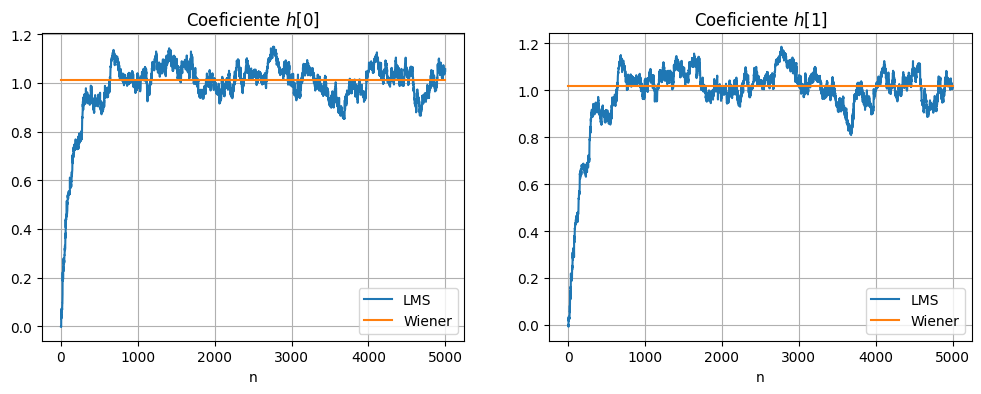

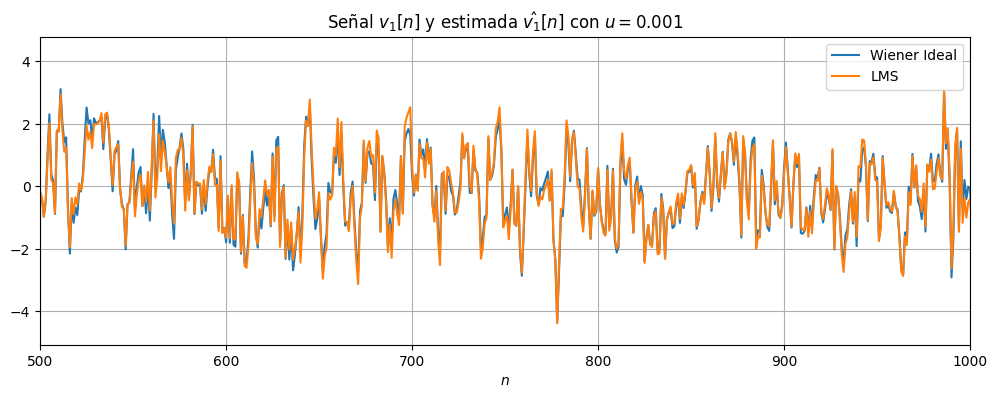

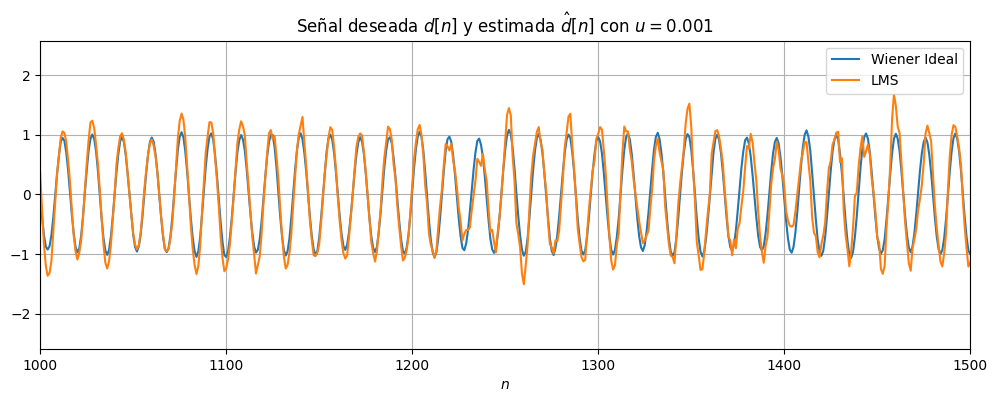

In [ ]:
h_LMS = np.zeros((M,N))
# v2[n] ingresa al filtro
vn2_LMS = np.zeros(N)

mu = 0.007
xx = np.zeros(M)
for n in range(N-1):
    xx = np.roll(xx,1)
    xx[0] = v2[n]
    vn2_LMS[n] = np.dot(h_LMS[:,n],xx)
    en = x[n] - vn2_LMS[n]
    h_LMS[:,n+1] = h_LMS[:,n] + 2 * mu * en * xx

# Hallamos el error o d[n] estimado
err_LMS = x - vn2_LMS

error_cuadratico_LMS = np.mean((err[N//2:] - err_LMS[N//2:]) ** 2)
print(f'Error cuadrático medio para u=0.001: ',error_cuadratico_LMS)
errores_cuadraticos.append(error_cuadratico_LMS)

# Graficamos h[0]
plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plt.plot(h_LMS[0,:])
plt.plot([0,N],[W[0],W[0]])
plt.grid('on')
plt.xlabel('n')
plt.title('Coeficiente $h[0]$')
plt.legend(['LMS','Wiener'])

# Graficamos h[1]
plt.subplot(1,2,2)
plt.plot(h_LMS[1,:])
plt.plot([0,N],[W[1],W[1]])
plt.grid('on')
plt.xlabel('n')
plt.title('Coeficiente $h[1]$')
plt.legend(['LMS','Wiener'])

# Comparando Wiener ideal vs. LMS con v1[n]
plt.figure(figsize=[12,4])
plt.plot(v1_estimado)
plt.plot(vn2_LMS)
plt.grid('on')
plt.xlabel('$n$')
plt.xlim([500,1000])
plt.title('Señal $v_1[n]$ y estimada $\hat{v_1}[n]$ con $u=0.001$')
plt.legend(['Wiener Ideal','LMS'])

# Comparando Wiener ideal vs. LMS en d[n]
plt.figure(figsize=[12, 4])
plt.plot(err)
plt.plot(err_LMS)
plt.legend(['Wiener Ideal','LMS'])
plt.xlabel('$n$')
plt.xlim([1000, 1500])
plt.title('Señal deseada $d[n]$ y estimada $\hat{d}[n]$ con $u=0.001$')
plt.grid('on')

### $\mu$ = 0.008

Error cuadrático medio para u=0.001:  0.07033042466834351


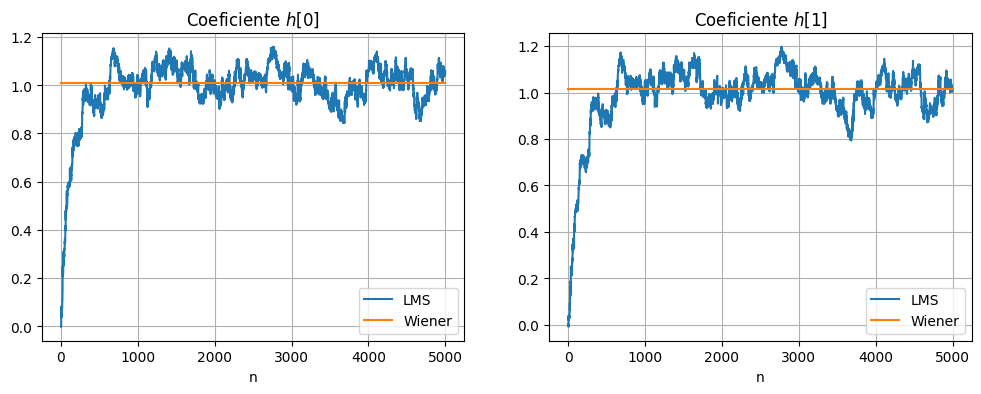

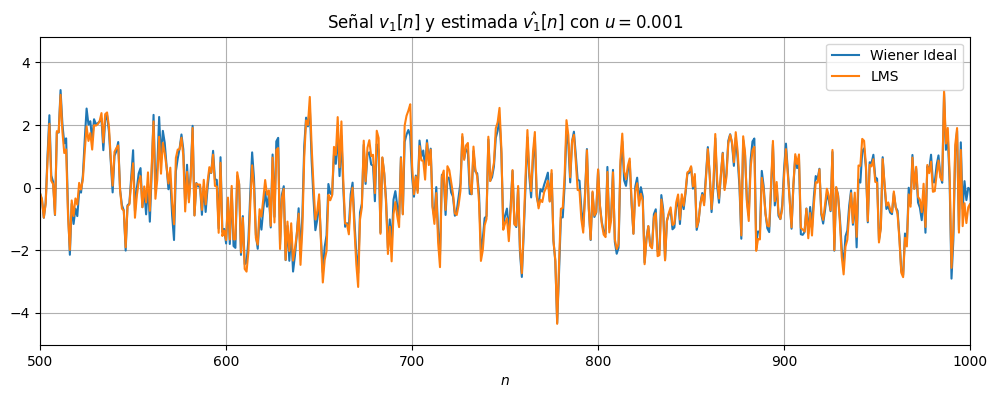

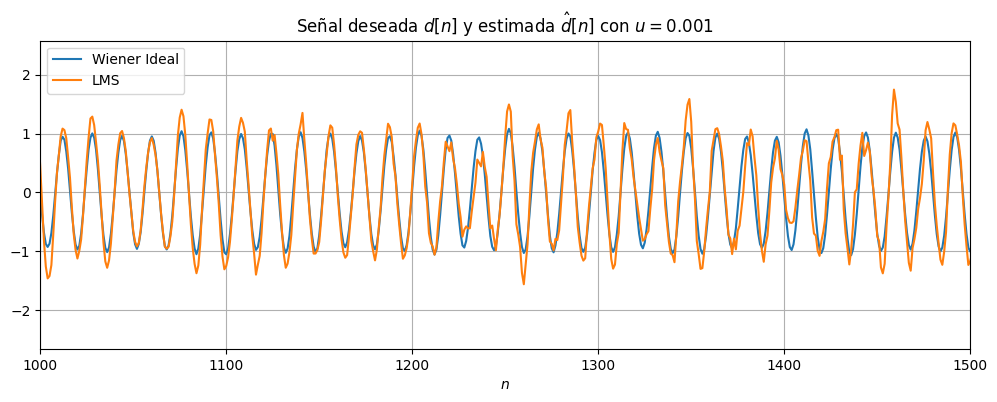

In [ ]:
h_LMS = np.zeros((M,N))
# v2[n] ingresa al filtro
vn2_LMS = np.zeros(N)

mu = 0.008
xx = np.zeros(M)
for n in range(N-1):
    xx = np.roll(xx,1)
    xx[0] = v2[n]
    vn2_LMS[n] = np.dot(h_LMS[:,n],xx)
    en = x[n] - vn2_LMS[n]
    h_LMS[:,n+1] = h_LMS[:,n] + 2 * mu * en * xx

# Hallamos el error o d[n] estimado
err_LMS = x - vn2_LMS

error_cuadratico_LMS = np.mean((err[N//2:] - err_LMS[N//2:]) ** 2)
print(f'Error cuadrático medio para u=0.001: ',error_cuadratico_LMS)
errores_cuadraticos.append(error_cuadratico_LMS)

# Graficamos h[0]
plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plt.plot(h_LMS[0,:])
plt.plot([0,N],[W[0],W[0]])
plt.grid('on')
plt.xlabel('n')
plt.title('Coeficiente $h[0]$')
plt.legend(['LMS','Wiener'])

# Graficamos h[1]
plt.subplot(1,2,2)
plt.plot(h_LMS[1,:])
plt.plot([0,N],[W[1],W[1]])
plt.grid('on')
plt.xlabel('n')
plt.title('Coeficiente $h[1]$')
plt.legend(['LMS','Wiener'])

# Comparando Wiener ideal vs. LMS con v1[n]
plt.figure(figsize=[12,4])
plt.plot(v1_estimado)
plt.plot(vn2_LMS)
plt.grid('on')
plt.xlabel('$n$')
plt.xlim([500,1000])
plt.title('Señal $v_1[n]$ y estimada $\hat{v_1}[n]$ con $u=0.001$')
plt.legend(['Wiener Ideal','LMS'])

# Comparando Wiener ideal vs. LMS en d[n]
plt.figure(figsize=[12, 4])
plt.plot(err)
plt.plot(err_LMS)
plt.legend(['Wiener Ideal','LMS'])
plt.xlabel('$n$')
plt.xlim([1000, 1500])
plt.title('Señal deseada $d[n]$ y estimada $\hat{d}[n]$ con $u=0.001$')
plt.grid('on')

In [ ]:
print(errores_cuadraticos)

[0.004451440463751494, 0.011180225484957377, 0.01949247365487197, 0.028377842556789545, 0.037783062116173445, 0.04780014909716713, 0.05858719484482974, 0.07033042466834351]


| $\mu$    | Error Cuadrático Medio              |
|----------|-------------------------------------|
| 0.001    | 0.004451440463751494                |
| 0.002    | 0.011180225484957377                |
| 0.003    | 0.01949247365487197                 |
| 0.004    | 0.028377842556789545                |
| 0.005    | 0.037783062116173445                |
| 0.006    | 0.04780014909716713                 |
| 0.007    | 0.05858719484482974                 |
| 0.008    | 0.07033042466834351                 |

> 1. ¿En qué caso se obtiene el menor error cuadrático?
> 
> Para este caso se puede observar claramente que el menor error cuadrático medio ocurre cuando el valor de $\mu$ es 0.001, esto significa que el algoritmo LMS podrá estimar con mucha presición los valores desde valores de $\mu$ bajos pero comprometiendo la velocidad del convergencia del algoritmo.
>
> 2. ¿En qué casos los coeficientes del algoritmo LMS convergen más rápido?
> 
> El algoritmo LMS converge mucho más rápido conforme se incremente el valor de $\mu$, cuando el valor de $\mu$ es mayor a 0.003 en adelante el algoritmo LMS convergerá rápidamente, se puede apreciar en las gráficas de resultados, aclarar que de incrementarse mucho el valor de $\mu$ también estamos añadiendo algo de error cuadrático medio, es recomendable quedarse con el valor de $\mu$ óptimo ya que tiene el menor error cuadrático y una velocidad de convergencia relativamente buena y muy similar a la que se obtendría con $\mu$ superiores.
>
> 3. ¿Cómo se relaciona la convergencia con la precisión en la estimación de los coeficientes del algoritmo LMS?
>
> Al igual que en la primera parte se puede sacrificar velocidad de convergencia por presición, depende mucho de la implementación y la aplicación que se le pueda dar al sistema, existe un compromiso entre la presición de la estimación de y la velocidad de convergencia, si nos excedemos del valor de $\mu$ óptimo estaríamos sacrificando presición por rapidez del algoritmo.